# Electric Production time series analysis and forecasting

Download dataset here: https://fred.stlouisfed.org/series/IPG2211A2N

Industrial Production: Utilities: Electric and Gas Utilities (NAICS = 2211,2) (IPG2211A2N)

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

For more information, see the explanatory notes issued by the Board of Governors. For recent updates, see the announcements issued by the Board of Governors

## Importing libaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import numpy as np
import math
from sklearn.metrics import mean_absolute_error
import seaborn as sns

## Dataset loading and cleaning


In [21]:
# Load the dataset
data = pd.read_csv('electricProduction.csv', parse_dates=['DATE'])
# Set the 'DATE' column as the index
data.set_index('DATE', inplace=True)


In [7]:
data

Value
DATE                
1939-01-01    3.3336
1939-02-01    3.3591
1939-03-01    3.4354
1939-04-01    3.4609
1939-05-01    3.4609
...              ...
2023-01-01  116.0803
2023-02-01  106.2589
2023-03-01  104.5990
2023-04-01   90.5375
2023-05-01   91.0514

[1013 rows x 1 columns]

In [22]:
data.dropna(inplace = True)

# rename the column with value
data.rename(columns = {'IPG2211A2N':'Value'}, inplace = True)

## Visualize dataset and the time series

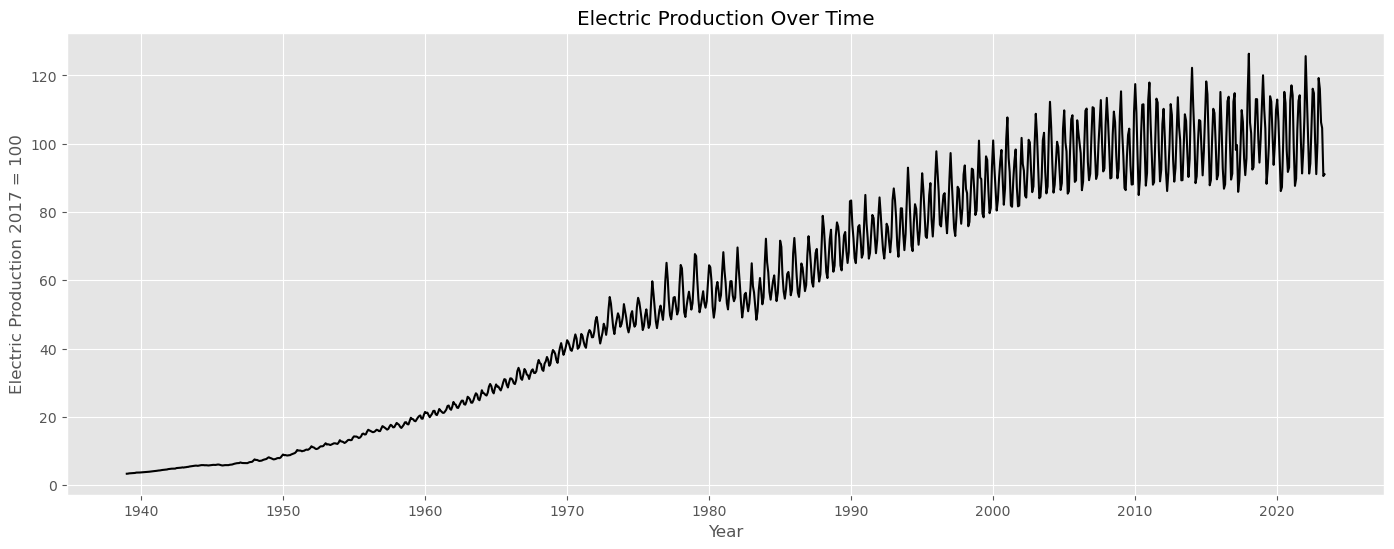

In [139]:
# Plot the time series plotting also the variance into the plot
plt.figure(figsize=(17, 6))
plt.plot(data.index, data['Value'], color='black')
#plt.fill_between(data.index, data['Value'] - data['Value'].rolling(window=12).var(), data['Value'] + data['Value'].rolling(window=12).var(), alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Electric Production 2017 = 100')
plt.title('Electric Production Over Time')
plt.show()




## Time series Analysis

### Overview

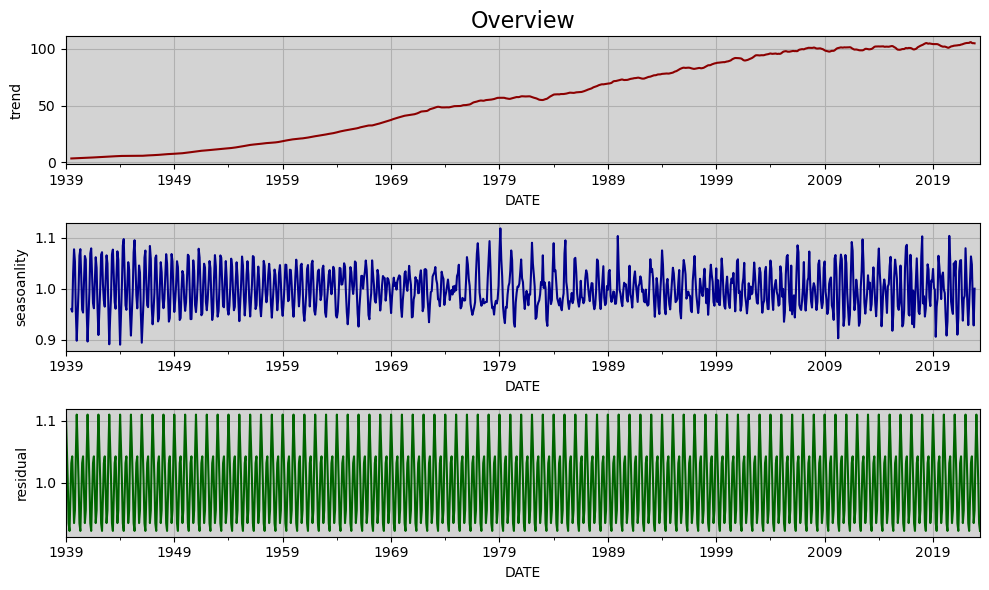

In [132]:
res = seasonal_decompose(data, model = "additive",period = 12)
resmul = seasonal_decompose(data, model = "multiplicative",period = 12)

# fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(10,6))
# res.trend.plot(ax=ax1,ylabel = "trend")
# res.resid.plot(ax=ax2,ylabel = "seasoanlity")
# res.seasonal.plot(ax=ax3,ylabel = "residual")

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(10,6))
resmul.trend.plot(ax=ax1,ylabel = "trend", color = "darkred")
resmul.resid.plot(ax=ax2,ylabel = "seasoanlity", color = "darkblue")
resmul.seasonal.plot(ax=ax3,ylabel = "residual", color = "darkgreen")
#backround of the plot
ax1.set_facecolor("lightgrey")
ax2.set_facecolor("lightgrey")
ax3.set_facecolor("lightgrey")
#grid
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
#title
ax1.set_title("Overview", fontsize = 16)

plt.tight_layout()



#res.plot()
#where trend is the trend over the time period, seasonal rapresent the seasonality of data anc residual is the error of the model in terms of difference between the real data and the predicted one
#seasonal_decompode makes the additive decomposition of the time series in trend, seasonality and residual using the moving average of the time series with a window of 12 months

### Stationarity

In [15]:
# Perform the Augmented Dickey-Fuller test
result = adfuller(data['Value'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(key, ':', value)

ADF Statistic: -0.738350527124623
p-value: 0.8365642894633367
Critical Values:
1% : -3.436972562223603
5% : -2.864463856182476
10% : -2.5683268054280175


 If the p-value is less than a chosen significance level (e.g., 0.05), we can reject the null hypothesis and conclude that the time series is stationary. Otherwise, if the p-value is greater than the significance level, we fail to reject the null hypothesis, suggesting that the time series is non-stationary.

In [12]:
#plot augmented dickey fuller test results 
def adf_test(series,title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

adf_test(data['Value'])


Augmented Dickey-Fuller Test: 
ADF test statistic       -0.738351
p-value                   0.836564
# lags used              22.000000
# observations          990.000000
critical value (1%)      -3.436973
critical value (5%)      -2.864464
critical value (10%)     -2.568327
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


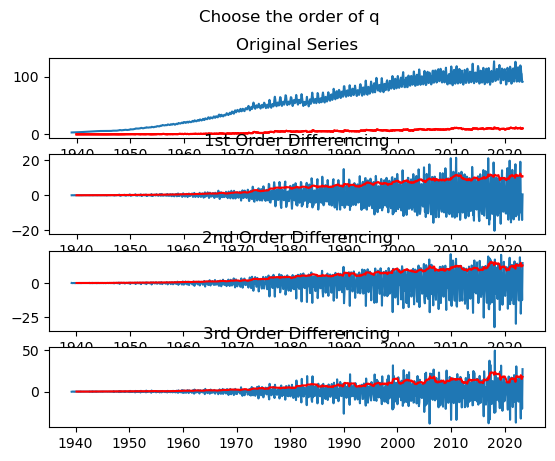

In [32]:
# choose the order of q 
#original series
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.suptitle('Choose the order of q')
ax1.plot(data['Value'])
#plot the standard deviation of the original series
ax1.plot(data['Value'].rolling(window=12).std(), color = 'red')
ax1.set_title('Original Series')
# 1st Differencing
ax2.plot(data['Value'].diff())
#plot the standard deviation of the 1st differencing series
ax2.plot(data['Value'].diff().rolling(window=12).std(), color = 'red')
ax2.set_title('1st Order Differencing')
# 2nd Differencing
ax3.plot(data['Value'].diff().diff())
#plot the standard deviation of the 2nd differencing series
ax3.plot(data['Value'].diff().diff().rolling(window=12).std(), color = 'red')
ax1.plot(data['Value'].rolling(window=12).std(), color = 'red')
ax3.set_title('2nd Order Differencing')
# 3rd Differencing
ax4.plot(data['Value'].diff().diff().diff())
#plot the standard deviation of the 3rd differencing series
ax4.plot(data['Value'].diff().diff().diff().rolling(window=12).std(), color = 'red')
ax1.plot(data['Value'].rolling(window=12).std(), color = 'red')
ax4.set_title('3rd Order Differencing')
plt.show()

# choose the order of p



### Trend and Stationarity Analysis

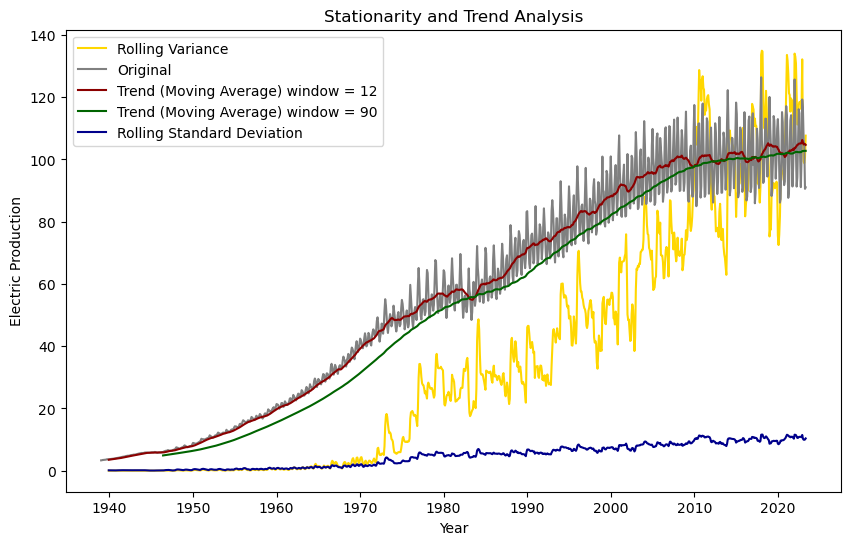

In [82]:
# Calculate the rolling mean (simple moving average) with a window size of 12 months
rolling_mean12 = data['Value'].rolling(window=12).mean()
rolling_mean90 = data['Value'].rolling(window=90).mean()
rolstd = data.rolling(window=12).std()
rolvar = data.rolling(window=12).var()

# Visualize the original time series and the trend component
plt.figure(figsize=(10, 6))
# plt.plot(data.index, data['Value'], label='Original')
plt.plot(data.index, rolvar, label='Rolling Variance', color = 'gold')
plt.plot(data.index, data['Value'], label='Original', color='grey')
plt.plot(data.index, rolling_mean12, label='Trend (Moving Average) window = 12', color = "darkred")
plt.plot(data.index, rolling_mean90, label='Trend (Moving Average) window = 90', color = 'darkgreen')
plt.plot(data.index, rolstd, label='Rolling Standard Deviation', color = 'darkblue')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Stationarity and Trend Analysis')
plt.legend()
plt.show()

# Calculate the rolling mean (simple moving average) with a window size of 365 


# Visualize the original time series and the trend component
# plt.figure(figsize=(10, 6))
# # plt.plot(data.index, data['Value'], label='Original')
# plt.plot(data.index, rolling_mean, color='red', label='Trend (Moving Average)')
# plt.xlabel('Year')
# plt.ylabel('Electric Production')
# plt.title('Trend Analysis: Electric Production \n window = 365')
# plt.legend()
# plt.show()



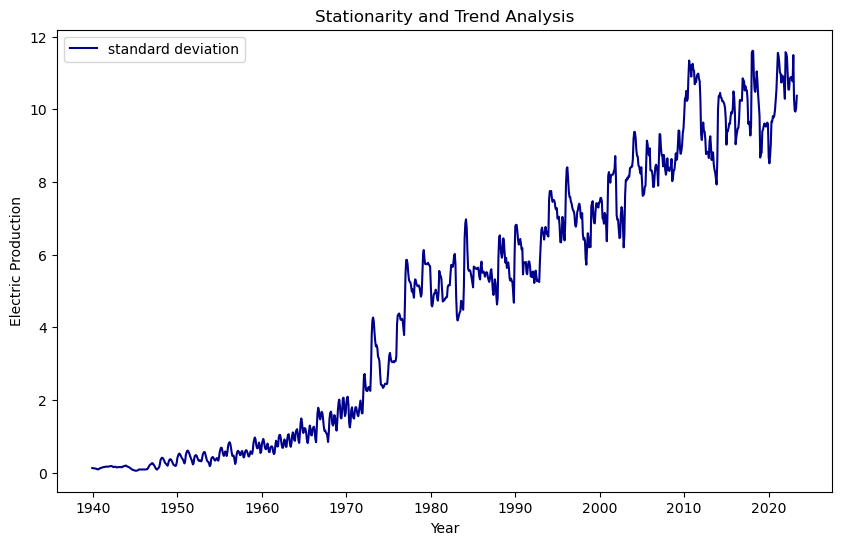

In [86]:
plt.figure(figsize=(10, 6))
# plt.plot(data.index, data['Value'], label='Original')
plt.plot(data.index, rolstd, label='standard deviation', color = "darkblue")
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Stationarity and Trend Analysis')
plt.legend()
plt.show()

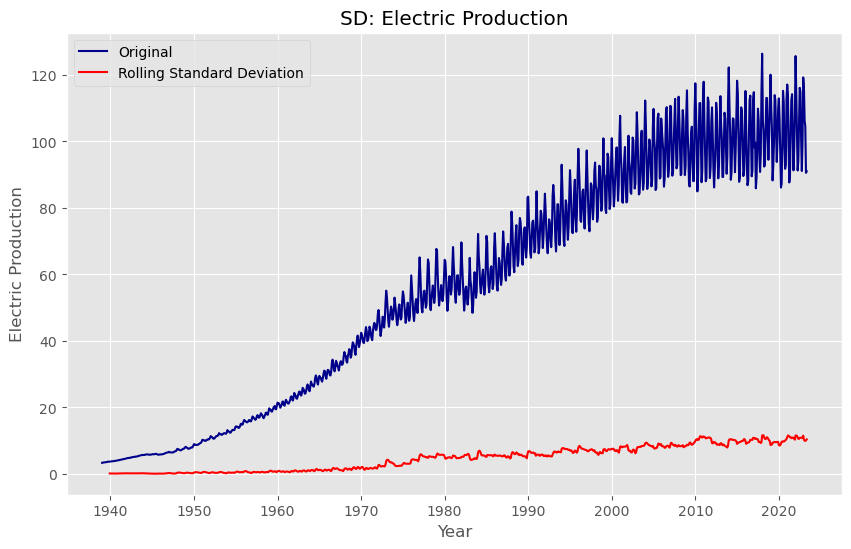

In [58]:
# Calculate the rolling SD with a window size of 12 months
rolstd = data.rolling(window=12).std()

# Visualize the original time series and the trend component
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Value'], label='Original', color='darkblue')
plt.plot(data.index, rolstd, color='red', label='Rolling Standard Deviation')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('SD: Electric Production')
plt.legend()
plt.show()

### Seasonality

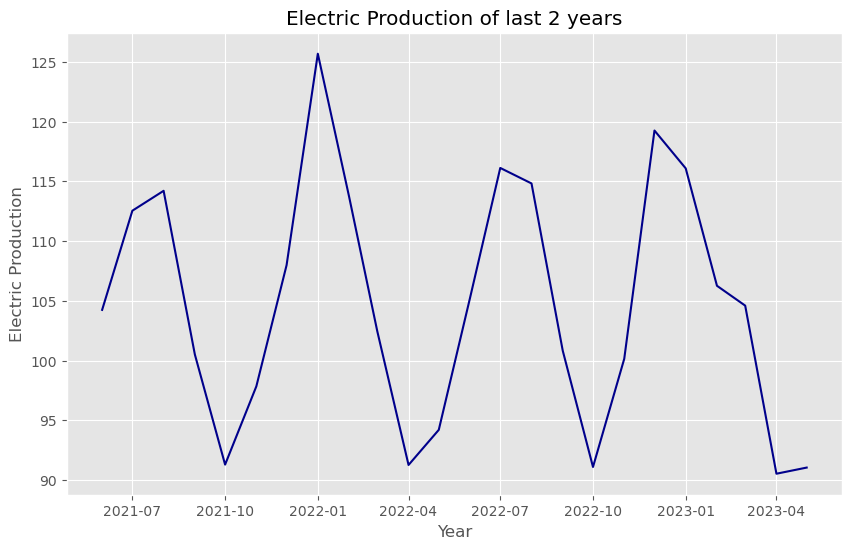

In [101]:
#plot of electric production of last x years
x = 2
plt.figure(figsize=(10, 6))
plt.plot(data.index[-12*x:], data['Value'][-12*x:], color='darkblue')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Electric Production of last {} years'.format(x))
plt.show()




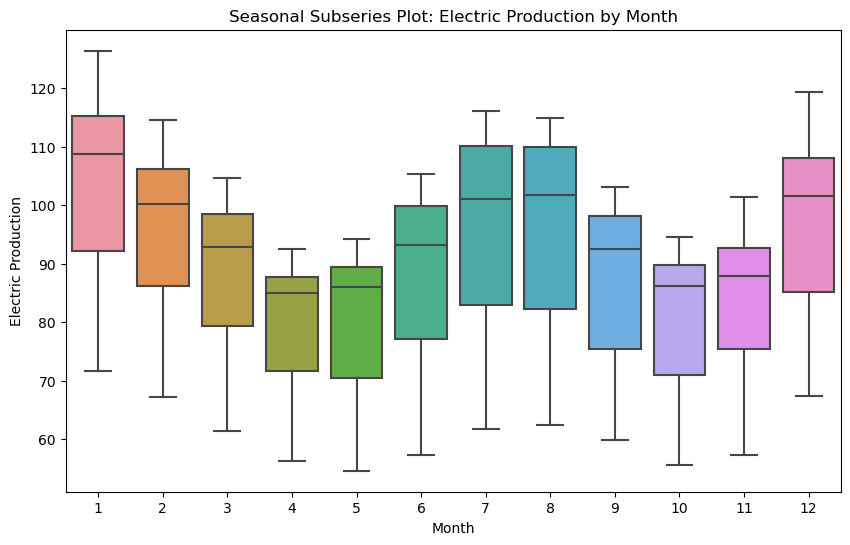

In [177]:
import seaborn as sns
#using just from 1985
data1985 = data[data.index.year >= 1985]
datacopy = data1985.copy()
datacopy['month'] = datacopy.index.month

# Calculate the average value for each month across all years
monthly_avg = datacopy.groupby('month')['Value'].mean()

# Create a seasonal subseries plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=datacopy['month'], y=datacopy['Value'])
plt.xlabel('Month')
plt.ylabel('Electric Production')
plt.title('Seasonal Subseries Plot: Electric Production by Month')
plt.show()

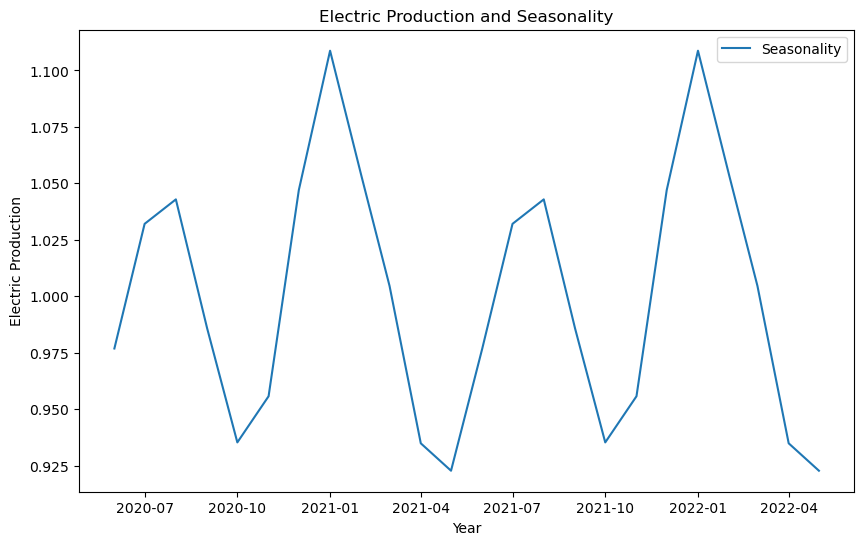

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(data["Value"], model='multiplicative', extrapolate_trend='freq')    
season = decomp.seasonal


# Create a new DataFrame with columns Month, Year, and Value
seasonality = data.copy()

#add seasonality to the dataframe
seasonality['Season'] = season

weeks_in_month = 4


seasonality['Temperature_seasonal_shift_r_2M'] = seasonality.Season.shift(-2*weeks_in_month)
seasonality['Temperature_seasonal_shift_r_1M'] = seasonality.Season.shift(-1*weeks_in_month)
seasonality['Temperature_seasonal_shift_1M'] = seasonality.Season.shift(1*weeks_in_month)
seasonality['Temperature_seasonal_shift_2M'] = seasonality.Season.shift(2*weeks_in_month)
seasonality['Temperature_seasonal_shift_3M'] = seasonality.Season.shift(3*weeks_in_month)


#plot with sns.lineplot just last 2 years
plt.figure(figsize=(10, 6))
#sns.lineplot(data=seasonality[-12*2:], x=seasonality[-12*2:].index, y='Value', label='Electric Production')
sns.lineplot(data=seasonality[-12*3:-12], x=seasonality[-12*3:-12].index, y='Season', label='Seasonality')
#sns.lineplot(data=seasonality[-12*3:-12], x=seasonality[-12*3:-12].index, y='Temperature_seasonal_shift_r_2M', label='Seasonality 2 months before')
#sns.lineplot(data=seasonality[-12*3:-12], x=seasonality[-12*3:-12].index, y='Temperature_seasonal_shift_r_1M', label='Seasonality 1 month before')
#sns.lineplot(data=seasonality[-12*3:-12], x=seasonality[-12*3:-12].index, y='Temperature_seasonal_shift_1M', label='Seasonality 1 month after')
# sns.lineplot(data=seasonality[-12*3:-12], x=seasonality[-12*3:-12].index, y='Temperature_seasonal_shift_2M', label='Seasonality 2 months after')
# sns.lineplot(data=seasonality[-12*3:-12], x=seasonality[-12*3:-12].index, y='Temperature_seasonal_shift_3M', label='Seasonality 3 months after')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Electric Production and Seasonality')
plt.legend()
plt.show()



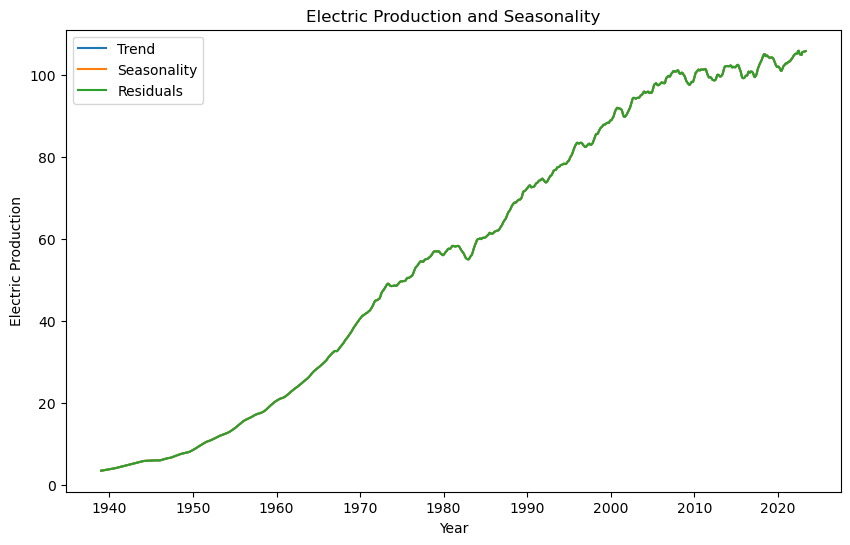

In [10]:
#trend with seasonal decomposition
plt.figure(figsize=(10, 6))
sns.lineplot(data=decomp.trend, x=decomp.trend.index, y=decomp.trend, label='Trend')
sns.lineplot(data=decomp.seasonal, x=decomp.seasonal.index, y=decomp.trend, label='Seasonality')
sns.lineplot(data=decomp.resid, x=decomp.resid.index, y=decomp.trend, label='Residuals')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Electric Production and Seasonality')
plt.legend()
plt.show()


### Autocorrelation

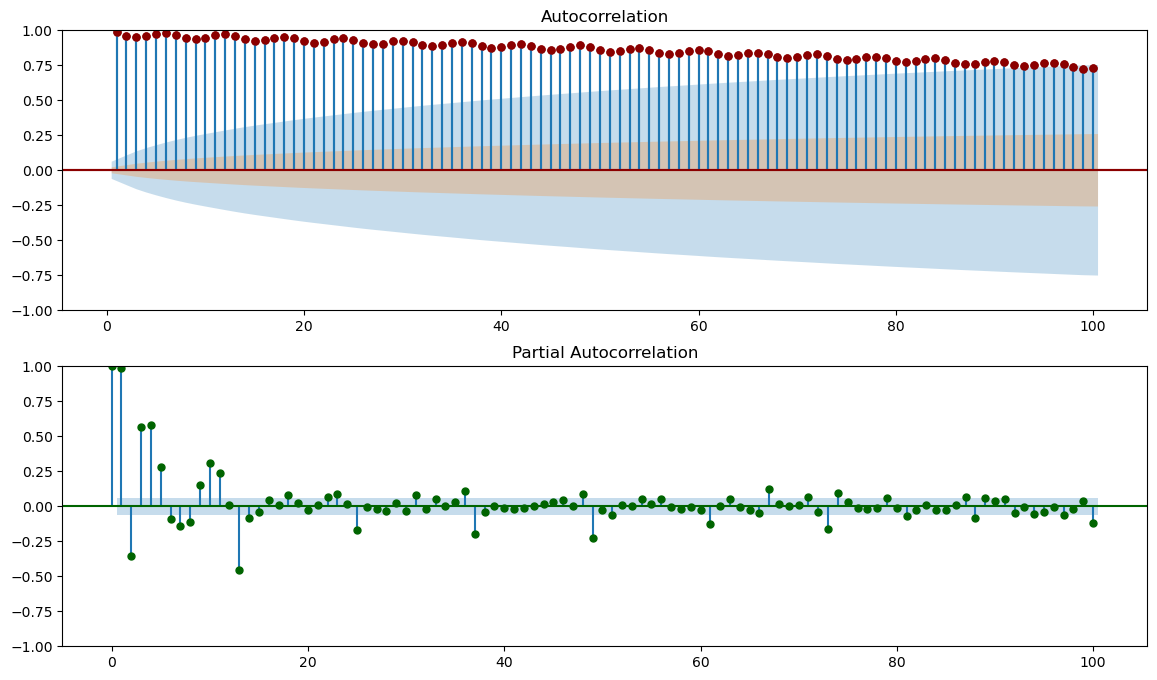

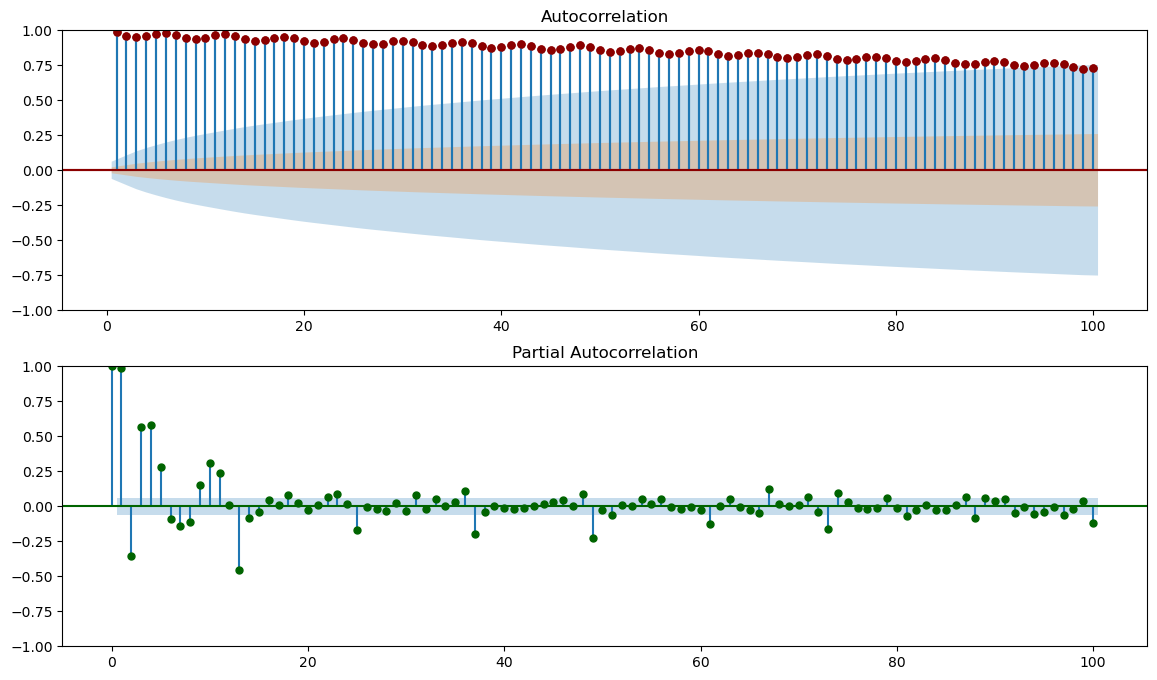

In [241]:
# autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14, 8))

# Make ACF plot of MA(1) model
# plot_acf(data['Value'], lags=50, zero=False, ax=ax1, color='darkblue')

# # Make PACF plot of MA(1) model
# plot_pacf(data['Value'], lags=50, zero=False, ax=ax2, color='darkgreen')

# Make ACF plot of MA(1) model
#plot_acf(data1985['Value'], lags=100, zero=False, ax=ax1, color='darkred')
plot_acf(data['Value'], lags=100, zero=False, ax=ax1, color='darkred')  

# Make PACF plot of MA(1) model
#plot_pacf(data1985['Value'], lags=100, zero=False, ax=ax2, color='darkgreen')
plot_pacf(data['Value'], lags=100, zero=True, ax=ax2, color='darkgreen')

#plor confidance interval
plot_acf(data['Value'], lags=100, zero=False, ax=ax1, color='darkred', alpha=0.5)




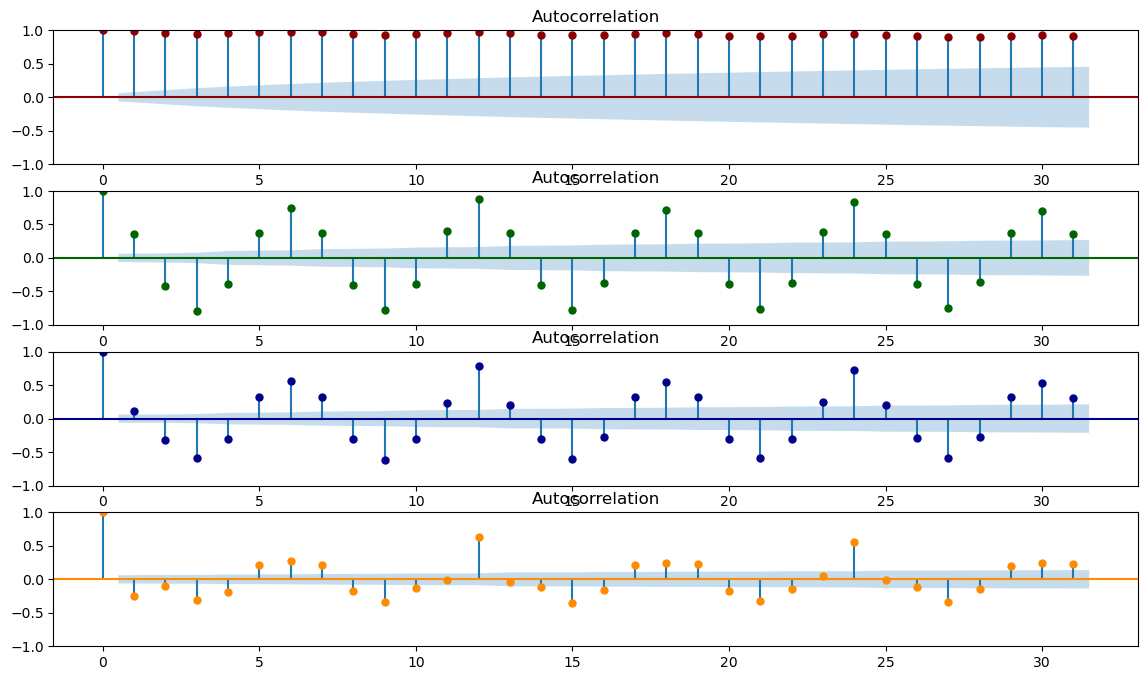

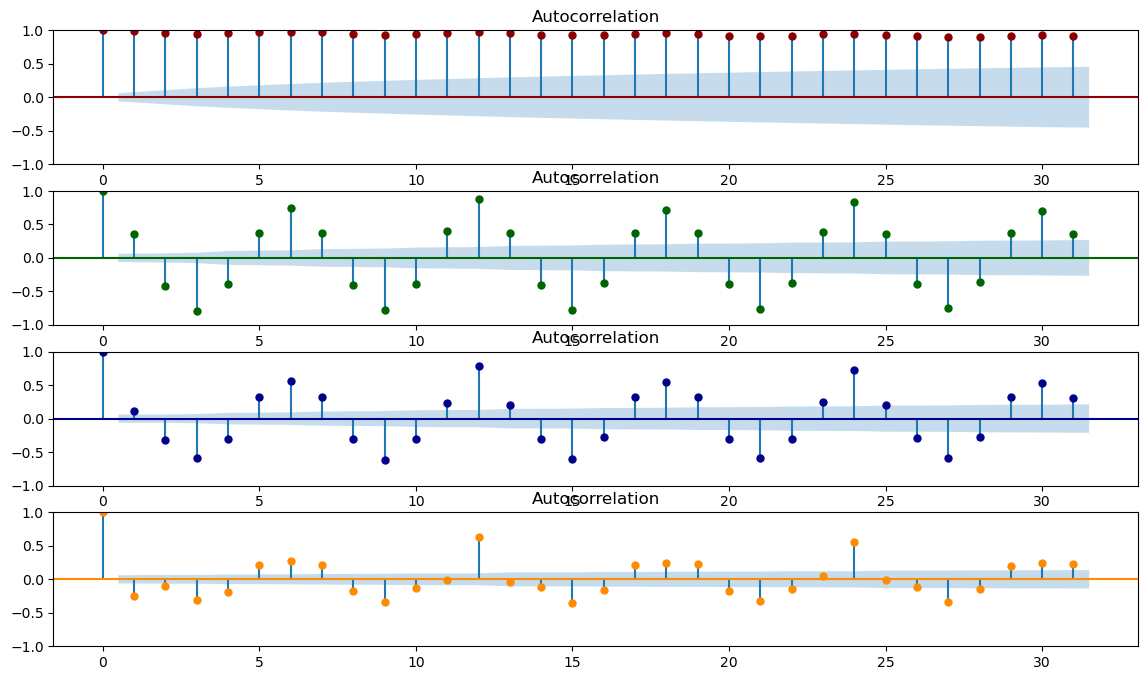

In [21]:
#plot autocorrelation with statsmodels

from statsmodels.tsa.stattools import acf, pacf

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(14, 8))
plot_acf(data['Value'], ax=ax1, color='darkred')
cplot_acf(data['Value'].diff().dropna(), ax=ax2, color='darkgreen')
plot_acf(data['Value'].diff().diff().dropna(), ax=ax3, color='darkblue')
plot_acf(data['Value'].diff().diff().diff().dropna(), ax=ax4, color='darkorange')

c:\Users\berna\anaconda3\envs\tsenv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


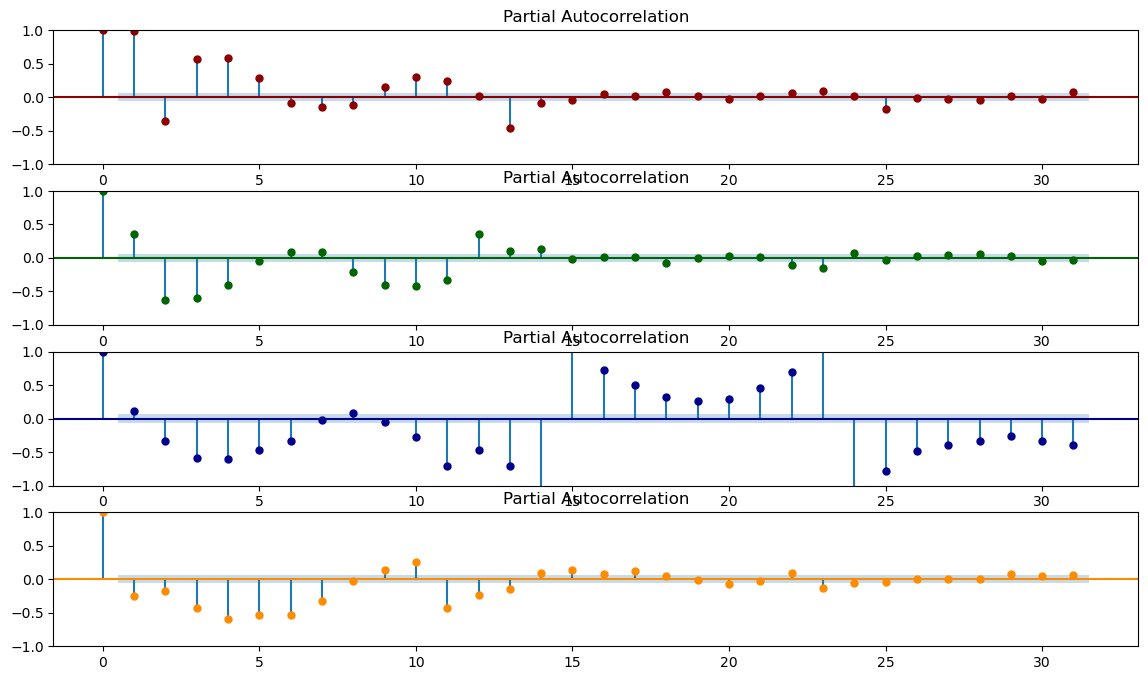

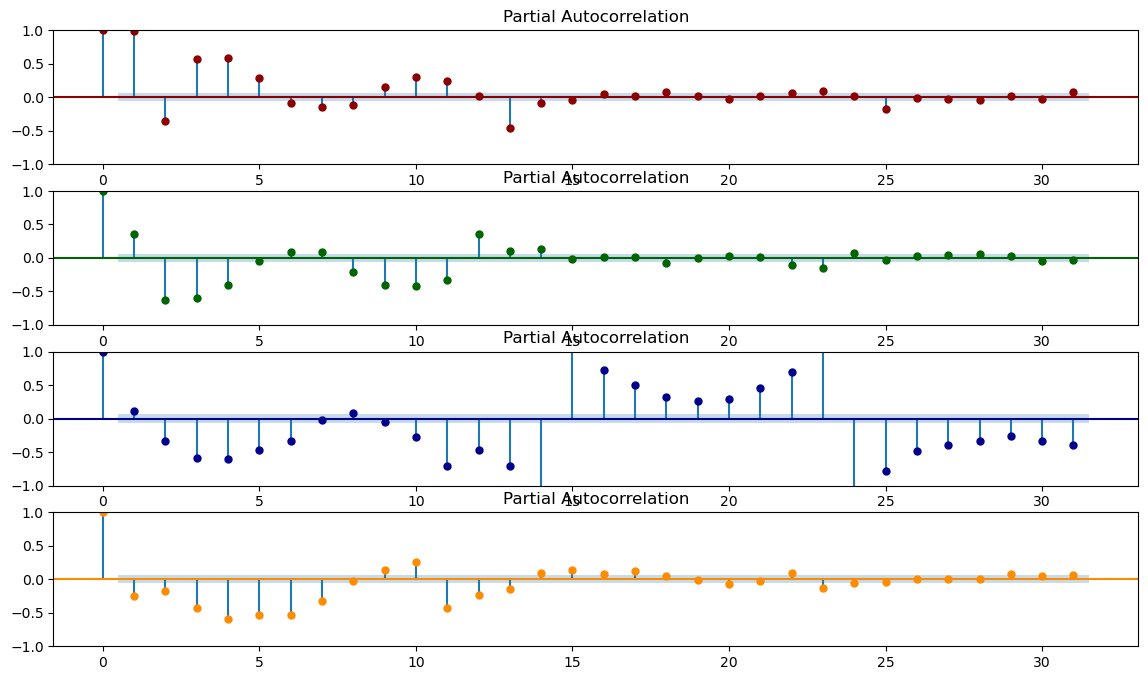

In [40]:
#plot partial autocorrelation with statsmodels
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(14, 8))
plot_pacf(data['Value'], ax=ax1, color='darkred')
plot_pacf(data['Value'].diff().dropna(), ax=ax2, color='darkgreen')
plot_pacf(data['Value'].diff().diff().dropna(), ax=ax3, color='darkblue')
plot_pacf(data['Value'].diff().diff().diff().dropna(), ax=ax4, color='darkorange')


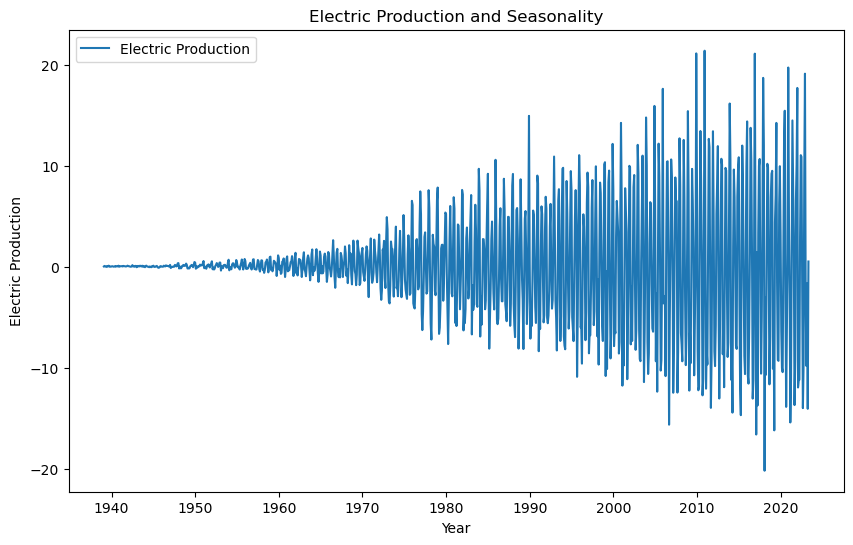

In [236]:
#plot differenced data
plt.figure(figsize=(10, 6))
sns.lineplot(data=data['Value'].diff().diff().diff().dropna(), x=data['Value'].diff().dropna().index, y=data['Value'].diff().dropna(), label='Electric Production')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Electric Production and Seasonality')
plt.legend()
plt.show()


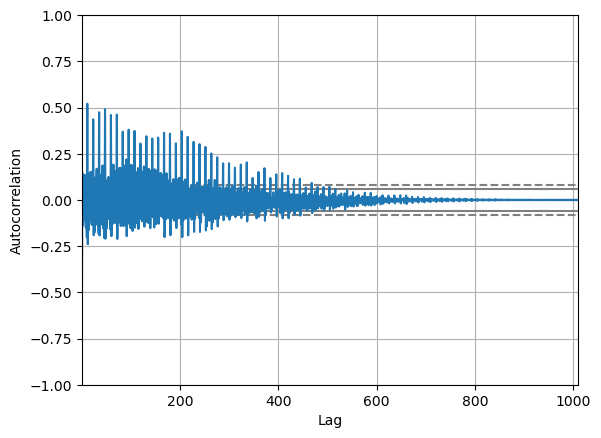

In [233]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data.Value.diff().dropna()) #plot autocorrelation with pandas
plt.show()

## Time series forecasting

#### Introduction

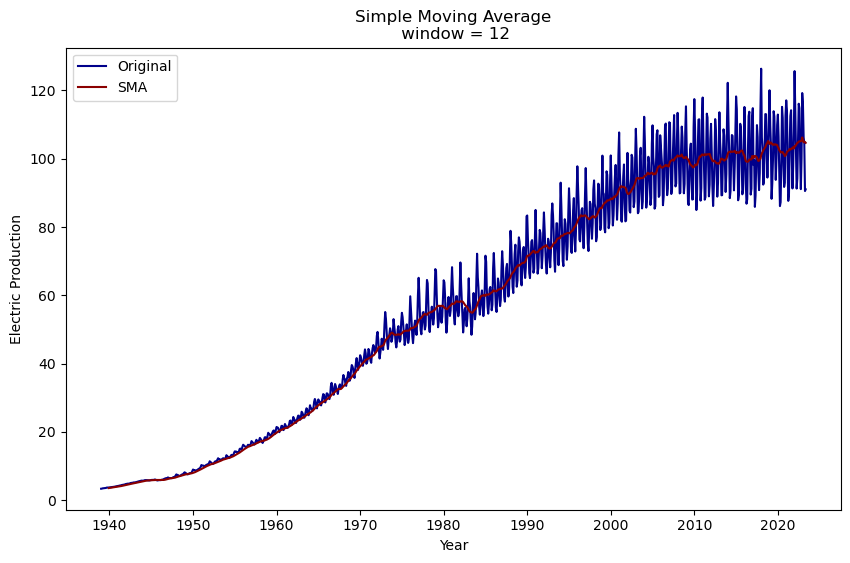

In [87]:
#classic moving average forecasting 
sma = data['Value'].rolling(window=12).mean() 
plt.figure(figsize=(10, 6)) 
plt.plot(data['Value'], label='Original', color='darkblue') 
plt.plot(sma, label='SMA', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Simple Moving Average' + '\n window = 12')
plt.legend()
plt.show()






### Data choosing
Train, validation and test sets

In [180]:
datasma = data.copy()

score_mae = []
score_rmse = []

datelimit = 2010
# Get indexes for training and test sets
train_index = datasma[data.index.year < datelimit].index
test_index = datasma[data.index.year == datelimit].index
X_train = datasma[datasma.index.year < datelimit]
X_test = datasma[datasma.index.year >= datelimit]
y_train = datasma[datasma.index.year < datelimit]['Value']
y_test = datasma[datasma.index.year >= datelimit]['Value']

# Initialize the prediction vector
y_test_pred = pd.Series(np.ones(len(y_test)))

### Moving Average approach

#### Model

In [42]:
#sns is note defined so I have to import it
import seaborn as sns


# Prediction: moving average
for i in range(len(y_test_pred)):
    y_test_pred.iloc[i] = y_train.append(y_test_pred.iloc[:(i)]).reset_index(drop=True).rolling(window=12).mean().iloc[-1]

# Calcuate metrics
score_mae.append(mean_absolute_error(y_test, y_test_pred))
score_rmse.append(math.sqrt(mean_squared_error(y_test, y_test_pred)))

#y_pred = pd.Series(np.zeros(len(X_test))) 
#for i in range(len(y_pred)):
    #use pd concat to add the previous predictions to the training set
    #y_pred.iloc[i] = y_train.append(y_pred.iloc[:(i)]).reset_index(drop=True).rolling(1).mean().iloc[-1]







C:\Users\berna\AppData\Local\Temp\ipykernel_6880\3115523035.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_test_pred.iloc[i] = y_train.append(y_test_pred.iloc[:(i)]).reset_index(drop=True).rolling(window=12).mean().iloc[-1]
C:\Users\berna\AppData\Local\Temp\ipykernel_6880\3115523035.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_test_pred.iloc[i] = y_train.append(y_test_pred.iloc[:(i)]).reset_index(drop=True).rolling(window=12).mean().iloc[-1]
C:\Users\berna\AppData\Local\Temp\ipykernel_6880\3115523035.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_test_pred.iloc[i] = y_train.append(y_test_pred.iloc[:(i)]).reset_index(drop=True).rolling(window=12).mean().iloc[-1]
C:\Users\berna\AppData\Local\Temp\ipy

#### Plot results

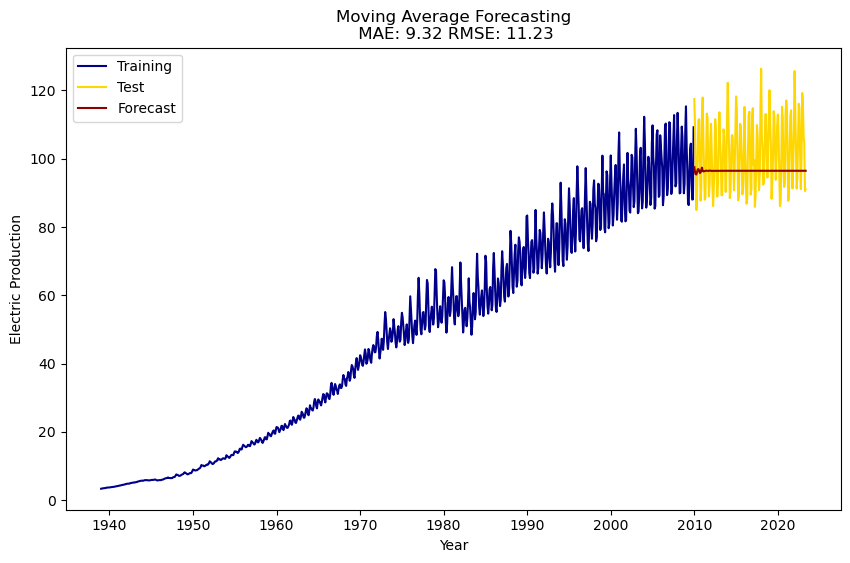

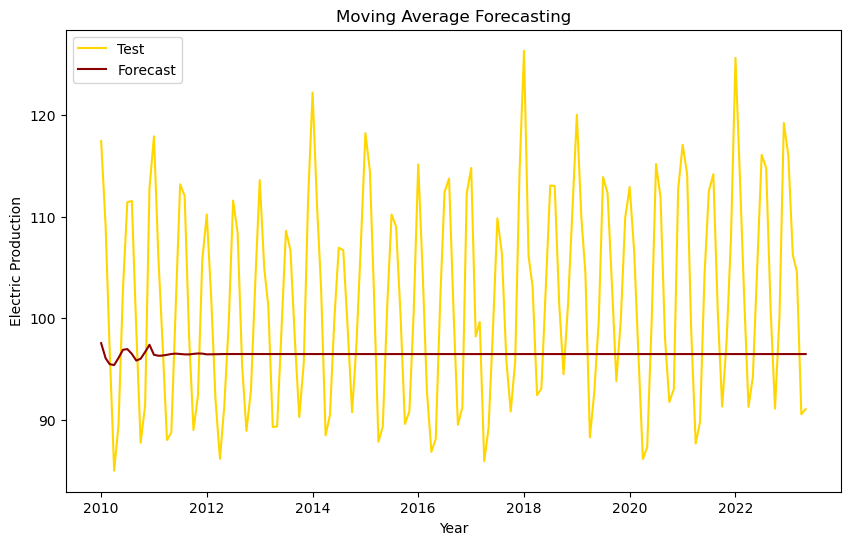

In [43]:
# Plot the forecast along with the original data with sns lineplot and ax limits and mae and rmse as title
plt.figure(figsize=(10, 6))
sns.lineplot(data=X_train, x=X_train.index, y=y_train, label='Training', color='darkblue')
sns.lineplot(data=X_test, x=X_test.index, y=y_test, label='Test', color='gold')
sns.lineplot(data=X_test, x=X_test.index, y=y_test_pred, label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Moving Average Forecasting' + '\n MAE: ' + str(round(score_mae[0], 2)) + ' RMSE: ' + str(round(score_rmse[0], 2)))
plt.legend()
plt.show()

#a focus just on the prediction between 2015 and 2018 
plt.figure(figsize=(10, 6))
sns.lineplot(data=X_test, x=X_test.index, y=y_test, label='Test', color='gold')
sns.lineplot(data=X_test, x=X_test.index, y=y_test_pred, label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Moving Average Forecasting')
plt.legend()
plt.show()



### Exponential Smoothing

c:\Users\berna\anaconda3\envs\tsenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


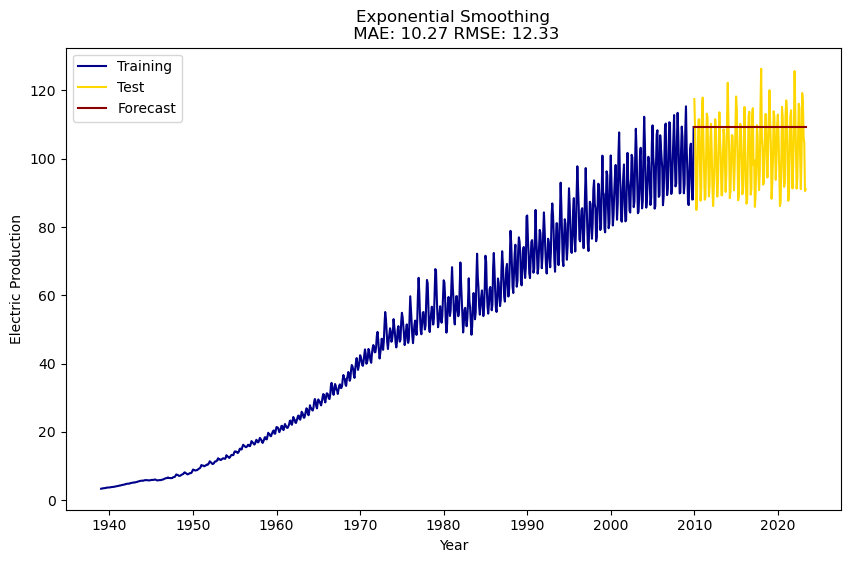

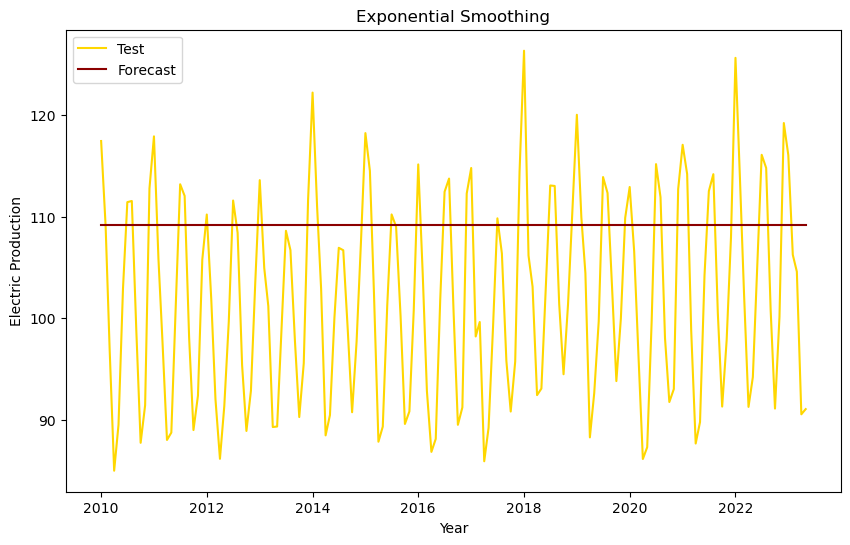

In [44]:
#exponential smoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

model = SimpleExpSmoothing(y_train, initialization_method="legacy-heuristic")

model_fit = model.fit()

forecast = model_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1)

plt.figure(figsize=(10, 6))
sns.lineplot(data=X_train, x=X_train.index, y=y_train, label='Training', color='darkblue')
sns.lineplot(data=X_test, x=X_test.index, y=y_test, label='Test', color='gold')
sns.lineplot(data=X_test, x=X_test.index, y=forecast, label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Exponential Smoothing' + '\n MAE: ' + str(round(mean_absolute_error(y_test, forecast), 2)) + ' RMSE: ' + str(round(math.sqrt(mean_squared_error(y_test, forecast)), 2)))
plt.legend()
plt.show()

#a focus just on the prediction 
plt.figure(figsize=(10, 6))
sns.lineplot(data=X_test, x=X_test.index, y=y_test, label='Test', color='gold')
sns.lineplot(data=X_test, x=X_test.index, y=forecast, label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Exponential Smoothing')
plt.legend()
plt.show()






### Double Exponential Smoothing

c:\Users\berna\anaconda3\envs\tsenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


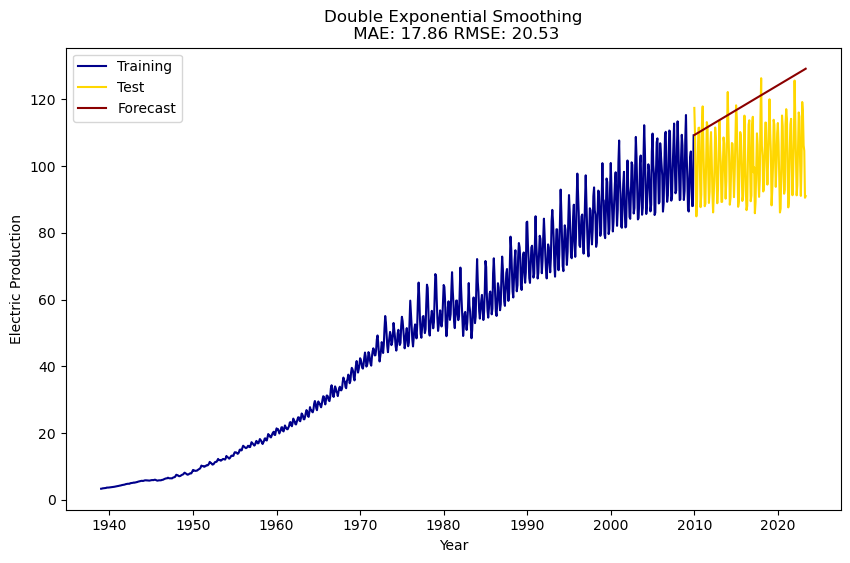

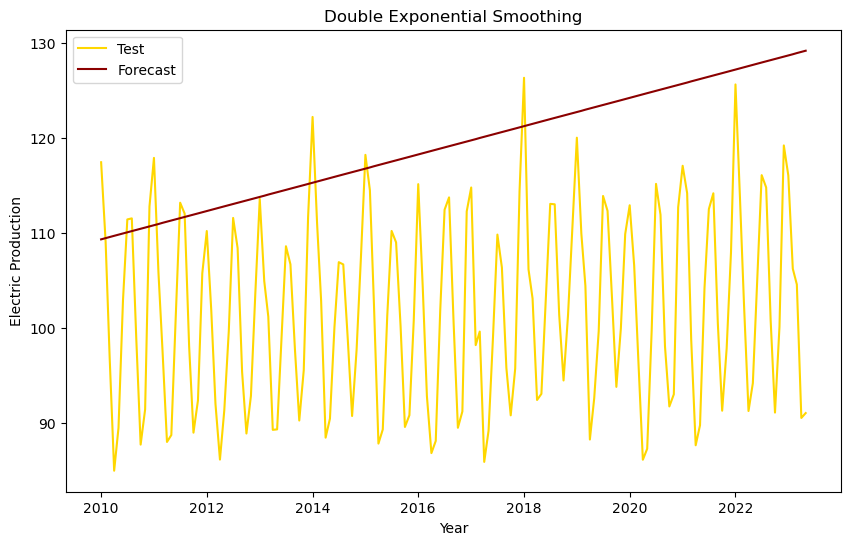

In [45]:
#double exponential smoothing
model = Holt(y_train, initialization_method="legacy-heuristic")
#other initialization methods are available
#model = Holt(y_train, initialization_method="estimated")
#another one
#model = Holt(y_train, initialization_method="heuristic")
model_fit = model.fit()

forecast = model_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1)

plt.figure(figsize=(10, 6))
sns.lineplot(data=X_train, x=X_train.index, y=y_train, label='Training', color='darkblue')
sns.lineplot(data=X_test, x=X_test.index, y=y_test, label='Test', color='gold')
sns.lineplot(data=X_test, x=X_test.index, y=forecast, label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Double Exponential Smoothing' + '\n MAE: ' + str(round(mean_absolute_error(y_test, forecast), 2)) + ' RMSE: ' + str(round(math.sqrt(mean_squared_error(y_test, forecast)), 2)))
plt.legend()
plt.show()

#a focus just on the prediction
plt.figure(figsize=(10, 6))
sns.lineplot(data=X_test, x=X_test.index, y=y_test, label='Test', color='gold')
sns.lineplot(data=X_test, x=X_test.index, y=forecast, label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Double Exponential Smoothing')
plt.legend()
plt.show()


### Triple Exponential Smoothing

c:\Users\berna\anaconda3\envs\tsenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


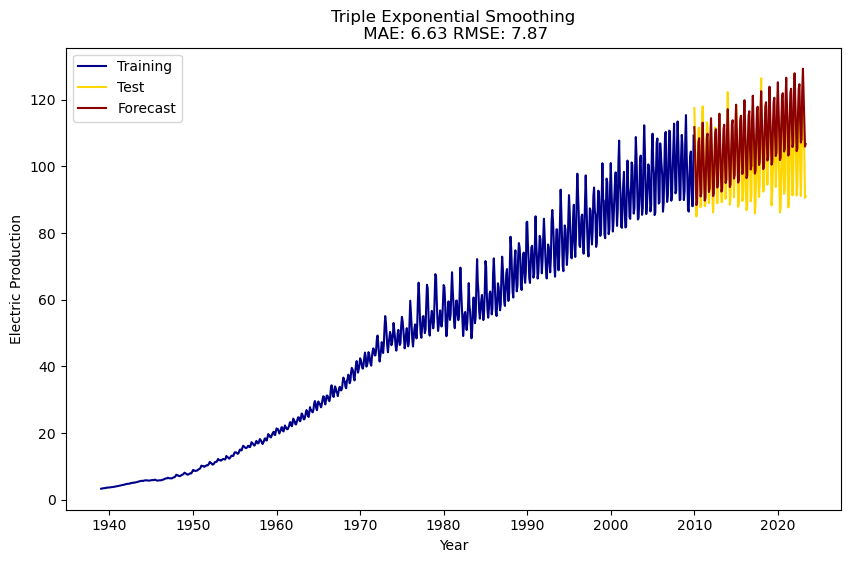

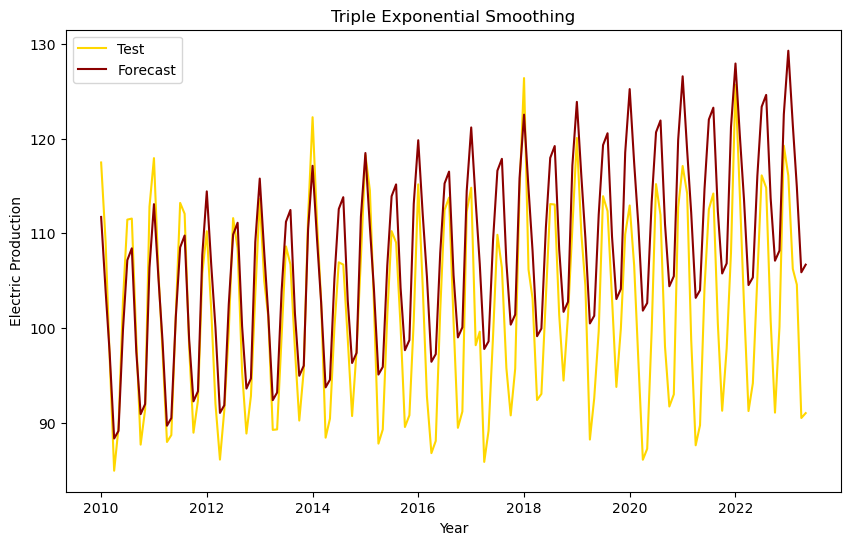

In [46]:
#triple exponential smoothing
model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=12, initialization_method="heuristic")

model_fit = model.fit()

forecast = model_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1)

plt.figure(figsize=(10, 6))
sns.lineplot(data=X_train, x=X_train.index, y=y_train, label='Training', color='darkblue')
sns.lineplot(data=X_test, x=X_test.index, y=y_test, label='Test', color='gold')
sns.lineplot(data=X_test, x=X_test.index, y=forecast, label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Triple Exponential Smoothing' + '\n MAE: ' + str(round(mean_absolute_error(y_test, forecast), 2)) + ' RMSE: ' + str(round(math.sqrt(mean_squared_error(y_test, forecast)), 2)))



#focus just on the prediction
plt.figure(figsize=(10, 6))
sns.lineplot(data=X_test, x=X_test.index, y=y_test, label='Test', color='gold')
sns.lineplot(data=X_test, x=X_test.index, y=forecast, label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Triple Exponential Smoothing')
plt.legend()
plt.show()


### Arima

Text(0.5, 1.0, 'ARIMA')

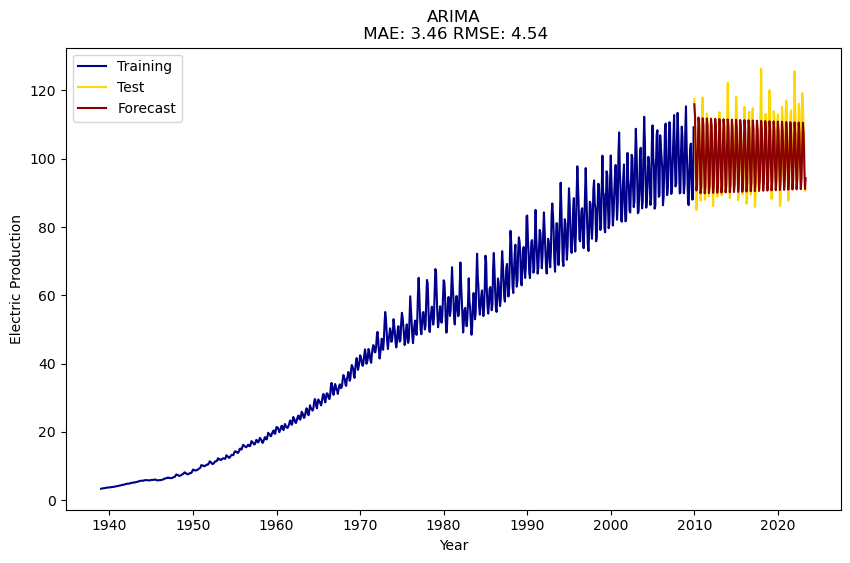

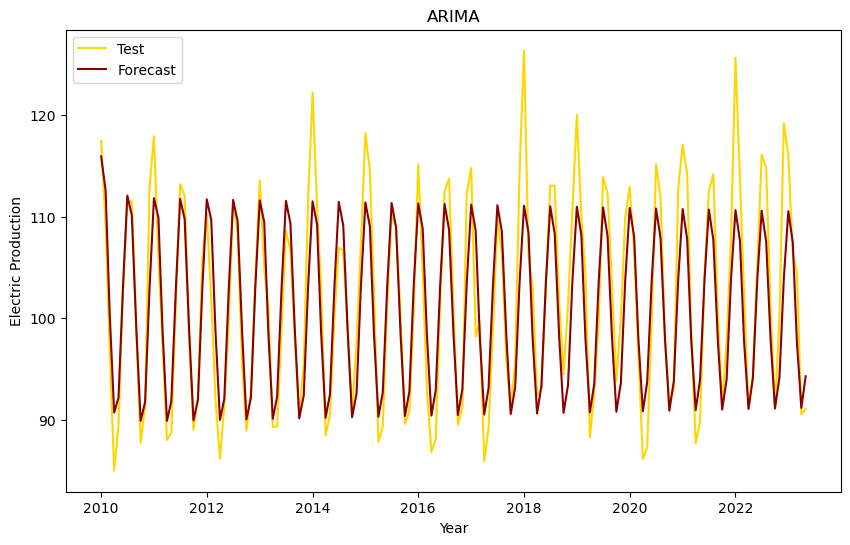

In [187]:
#arima model
from statsmodels.tsa.arima.model import ARIMA

# ARIMA(1,1,2)(2,0,2)[6]             : AIC=3409.062, Time=1.24 sec
#model = ARIMA(y_train, order=(3, 1, 3))
#model = ARIMA(y_train, order=(3, 1, 2))
model = ARIMA(y_train, order=(4, 1, 4))
#model = ARIMA(y_train, order=(3, 2, 2), seasonal_order=(2, 1, 2, 6))
model_fit = model.fit()


forecast = model_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1)

plt.figure(figsize=(10, 6))
sns.lineplot(data=X_train, x=X_train.index, y=y_train, label='Training', color='darkblue')
sns.lineplot(data=X_test, x=X_test.index, y=y_test, label='Test', color='gold')
sns.lineplot(data=X_test, x=X_test.index, y=forecast, label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('ARIMA' + '\n MAE: ' + str(round(mean_absolute_error(y_test, forecast), 2)) + ' RMSE: ' + str(round(math.sqrt(mean_squared_error(y_test, forecast)), 2)))

#focus just on the prediction
plt.figure(figsize=(10, 6))
sns.lineplot(data=X_test, x=X_test.index, y=y_test, label='Test', color='gold')
sns.lineplot(data=X_test, x=X_test.index, y=forecast, label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('ARIMA')



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4971.775, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4848.588, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4709.070, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4970.431, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4709.877, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4515.267, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4437.972, Time=0.43 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3724.100, Time=1.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3998.615, Time=0.70 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3717.196, Time=1.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4007.915, Time=0.73 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3714.683, Time=1.93 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3976.345, Time=0.44 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=3733.628, Time=1.29 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept

Text(0.5, 1.0, 'Auto ARIMA\n MAE: 9.16 RMSE: 10.53')

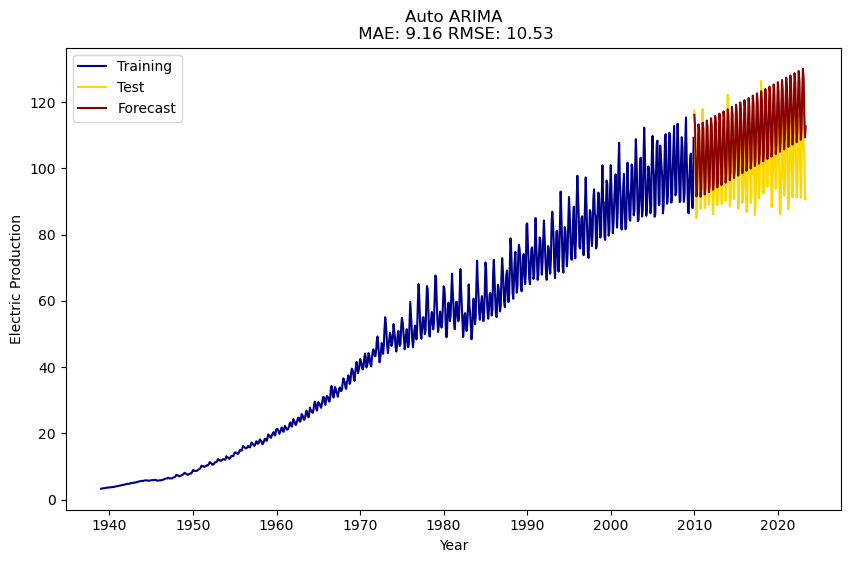

In [185]:
#auto arima no seasonal
from pmdarima.arima import auto_arima

model = auto_arima(y_train, start_p=0, start_q=0, max_p=5, max_q=5, trace=True, information_criterion = 'aic')

model_fit = model.fit(y_train)

forecast = model_fit.predict(n_periods=len(y_test))

plt.figure(figsize=(10, 6))
sns.lineplot(data=X_train, x=X_train.index, y=y_train, label='Training', color='darkblue')
sns.lineplot(data=X_test, x=X_test.index, y=y_test, label='Test', color='gold')
sns.lineplot(data=X_test, x=X_test.index, y=forecast, label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Auto ARIMA' + '\n MAE: ' + str(round(mean_absolute_error(y_test, forecast), 2)) + ' RMSE: ' + str(round(math.sqrt(mean_squared_error(y_test, forecast)), 2)))



In [75]:
model = auto_arima(y_train, seasonal=True, trace=True, m=2, approximation=False)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[2] intercept   : AIC=5030.251, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : AIC=5503.962, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : AIC=5212.677, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[2] intercept   : AIC=5034.082, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[2]             : AIC=5502.447, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[2] intercept   : AIC=5034.256, Time=0.27 sec
 ARIMA(1,1,1)(1,0,0)[2] intercept   : AIC=5146.042, Time=0.26 sec
 ARIMA(1,1,1)(2,0,1)[2] intercept   : AIC=4473.115, Time=0.89 sec
 ARIMA(1,1,1)(2,0,0)[2] intercept   : AIC=4589.508, Time=0.65 sec
 ARIMA(1,1,1)(2,0,2)[2] intercept   : AIC=3990.402, Time=1.16 sec
 ARIMA(1,1,1)(1,0,2)[2] intercept   : AIC=4974.986, Time=0.53 sec
 ARIMA(0,1,1)(2,0,2)[2] intercept   : AIC=4062.557, Time=1.09 sec
 ARIMA(1,1,0)(2,0,2)[2] intercept   : AIC=4069.965, Time=1.14 sec
 ARIMA(0,1,0)(2,0,2)[2] intercept   : AIC=4061.443, Time=1.05 sec
 ARIMA(1,1,1)(2,0,2)[2]          

In [77]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  912
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 2)   Log Likelihood               -1987.201
Date:                                Fri, 23 Jun 2023   AIC                           3990.402
Time:                                        18:31:22   BIC                           4028.918
Sample:                                    01-01-1939   HQIC                          4005.107
                                         - 12-01-2014                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1245      0.015      8.588      0.000       0.096       0.153
ar.L1          0.6591      0.024     27.126      0.000       0.611       0.707
ma.L1         -0.9554      0.009   -103.002      0.000      -0.974      -0.937
ar.S.L2       -0.9963      0.003   -330.973      0.000      -1.002      -0.990
ar.S.L4       -0.9929      0.003   -315.785      0.000      -0.999      -0.987
ma.S.L2        0.8673      0.023     37.366      0.000       0.822       0.913
ma.S.L4        0.8408      0.023     36.034      0.000       0.795       0.887
sigma2         4.5918      0.158     29.148      0.000       4.283       4.901
===================================================================================
Ljung-Box (L1) (Q):                  11.28   Jarque-Bera (JB):               240.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              38.87   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Seasonal AutoArima

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3251.841, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4971.775, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4226.384, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4970.431, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=4337.612, Time=0.35 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=3253.386, Time=1.85 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3253.049, Time=1.62 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=4060.337, Time=0.65 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=3249.463, Time=2.69 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=3232.846, Time=4.18 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3235.394, Time=2.20 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept

Text(0.5, 1.0, 'Auto ARIMA\n MAE: 2.96 RMSE: 3.69')

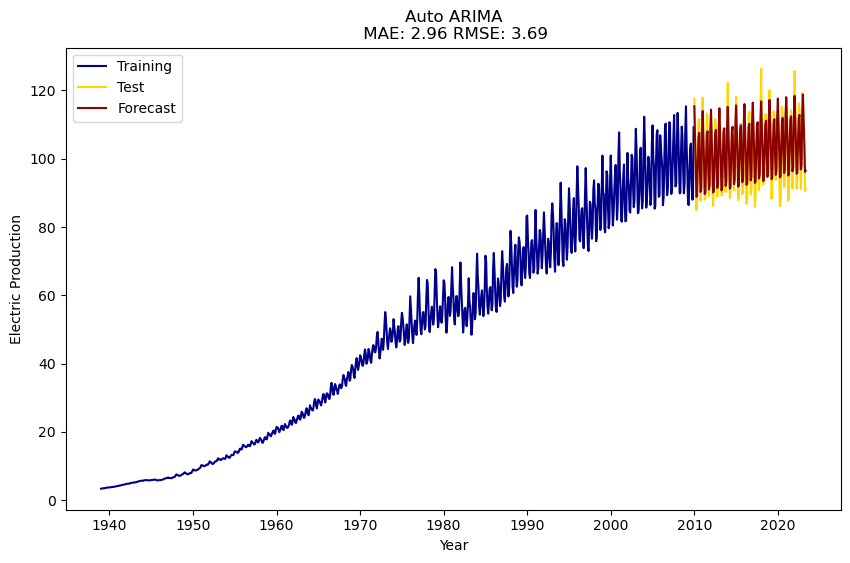

In [188]:
#import auto arima with seasonal
from pmdarima.arima import auto_arima
#import auto.arima
#auto arima with seasonal but not choosen at prior
model = auto_arima(y_train, start_p=0, start_q=0, max_p=6, max_q=6, seasonal=True, trace=True, m=12)
# FOR EVERY PARAMETERS
# model = auto_arima(y_train, seasonal=True,stepwise=FALSE, approximation=FALSE))
#model = auto_arima(y_train)

model_fit = model.fit(y_train)

forecast = model_fit.predict(n_periods=len(y_test))

plt.figure(figsize=(10, 6))
sns.lineplot(data=X_train, x=X_train.index, y=y_train, label='Training', color='darkblue')
sns.lineplot(data=X_test, x=X_test.index, y=y_test, label='Test', color='gold')
sns.lineplot(data=X_test, x=X_test.index, y=forecast, label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Auto ARIMA' + '\n MAE: ' + str(round(mean_absolute_error(y_test, forecast), 2)) + ' RMSE: ' + str(round(math.sqrt(mean_squared_error(y_test, forecast)), 2)))




### Sarima

#### Model

In [189]:
#sarima model
from statsmodels.tsa.statespace.sarimax import SARIMAX

#model = SARIMAX(y_train, order=(3, 1, 2), seasonal_order=(2, 1, 1, 12)) 
#model = SARIMAX(y_train, order=(1, 1, 2), seasonal_order=(1, 0, 1, 12))  #in generic term (p,d,q) and (P,D,Q,m) 
#retry using this parameters 540.7461113084696 {'D': 0, 'P': 1, 'Q': 0, 'd': 0, 'p': 1, 'q': 0}
#model = SARIMAX(y_train, order=(1, 0, 0), seasonal_order=(1, 0, 0, 12))
#best model Best model:  ARIMA(3,1,3)(2,1,2)[12]   
#model = SARIMAX(y_train, order=(3, 1, 3), seasonal_order=(2, 1, 2, 12))
#14.0 {'D': 0, 'P': 2, 'Q': 0, 'd': 0, 'p': 3, 'q': 1}
#10.0 {'D': 0, 'P': 2, 'Q': 1, 'd': 0, 'p': 0, 'q': 1}
#AUTOARIMA Best model:  ARIMA(3,1,3)(2,1,2)[12] 
#model = SARIMAX(y_train, order=(3, 1, 2), seasonal_order=(2, 1, 1, 12))
#model = SARIMAX(endog = y_train, order=(3, 1, 1), seasonal_order=(2, 0, 2, 12))

model = SARIMAX(endog = y_train, order=(5, 1, 1), seasonal_order=(2, 0, 2, 12))
model_fit = model.fit()

forecast = model_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1)



In [147]:
X_train_diff = X_train.diff().dropna()
X_test_diff = X_test.diff().dropna()
y_train_diff = y_train.diff().dropna()
y_test_diff = y_test.diff().dropna()

model_diff = SARIMAX(endog = y_train_diff, order=(3, 1, 1), seasonal_order=(2, 0, 2, 12))
model_fit_diff = model_diff.fit()

forecast_diff = model_fit_diff.predict(start=len(y_train_diff), end=len(y_train_diff)+len(y_test_diff)-1)
mae = mean_absolute_error(y_test_diff, forecast_diff)
rmse = math.sqrt(mean_squared_error(y_test_diff, forecast_diff))
forecast_diff = y_train.iloc[-1] + forecast_diff.cumsum()

plt.figure(figsize=(10, 6))
sns.lineplot(data=X_train, x=X_train.index, y=y_train, label='Training', color='darkblue')
sns.lineplot(data=X_test, x=X_test.index, y=y_test, label='Test', color='gold')
sns.lineplot(data=X_test_diff, x=X_test_diff.index, y=forecast_diff, label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('SARIMA' + '\n MAE: ' + str(round(mae, 2)) + ' RMSE: ' + str(round(rmse, 2)))

c:\Users\berna\anaconda3\envs\tsenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\berna\anaconda3\envs\tsenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\berna\anaconda3\envs\tsenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ValueError: Found input variables with inconsistent numbers of samples: [161, 160]

In [30]:
forecast

2006-01-01    115.017313
2006-02-01    106.743465
2006-03-01     99.792892
2006-04-01     89.741033
2006-05-01     90.815015
                 ...    
2023-01-01    146.831538
2023-02-01    138.480619
2023-03-01    129.266294
2023-04-01    118.625012
2023-05-01    120.760554
Freq: MS, Name: predicted_mean, Length: 209, dtype: float64

#### Plot

Text(0.5, 1.0, 'SARIMA')

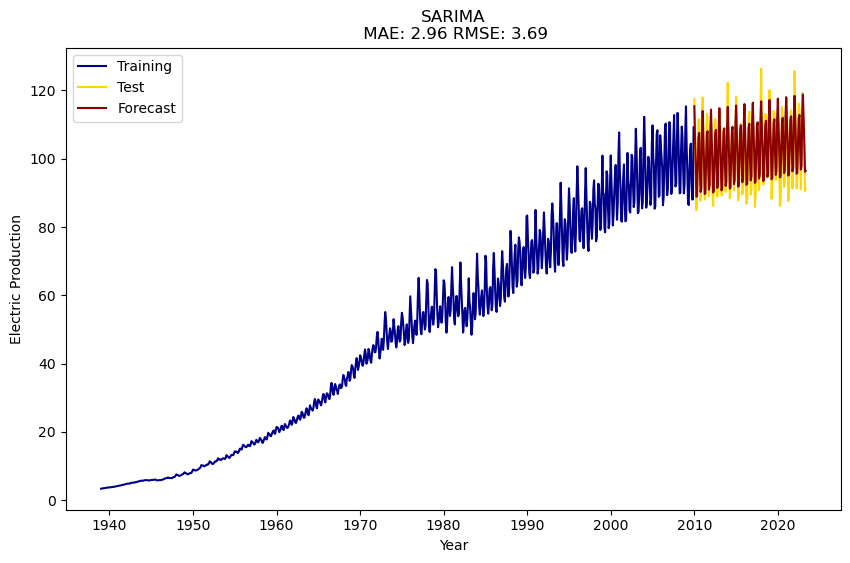

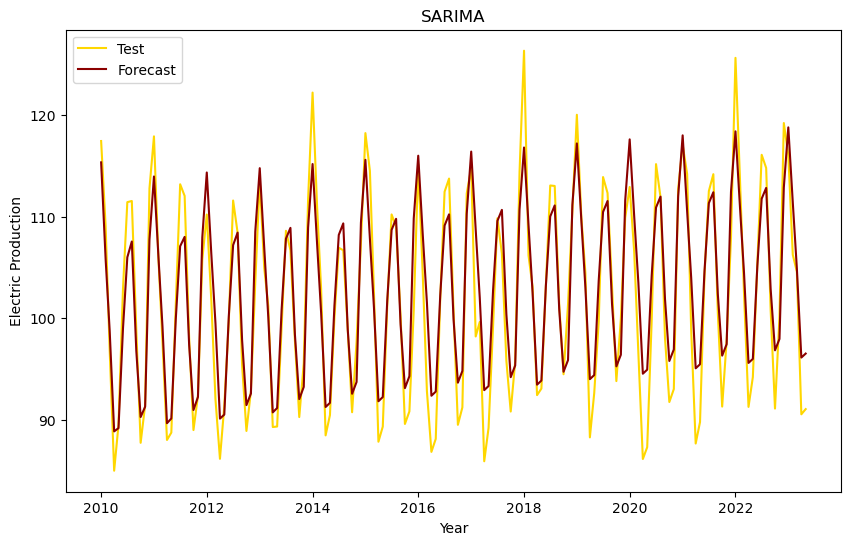

In [190]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=X_train, x=X_train.index, y=y_train, label='Training', color='darkblue')
sns.lineplot(data=X_test, x=X_test.index, y=y_test, label='Test', color='gold')
sns.lineplot(data=X_test, x=X_test.index, y=forecast, label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('SARIMA' + '\n MAE: ' + str(round(mean_absolute_error(y_test, forecast), 2)) + ' RMSE: ' + str(round(math.sqrt(mean_squared_error(y_test, forecast)), 2)))


plt.figure(figsize=(10, 6))
sns.lineplot(data=X_test, x=X_test.index, y=y_test, label='Test', color='gold')
sns.lineplot(data=X_test, x=X_test.index, y=forecast, label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('SARIMA')



#### Loss and residuals

In [69]:
residuals = pd.DataFrame(model_fit.resid)
residuals

0
DATE                
1939-01-01  3.333600
1939-02-01  0.025514
1939-03-01  0.080086
1939-04-01  0.046225
1939-05-01  0.031215
...              ...
2009-08-01 -0.306611
2009-09-01 -1.602019
2009-10-01 -0.060877
2009-11-01 -2.791977
2009-12-01  6.050228

[852 rows x 1 columns]

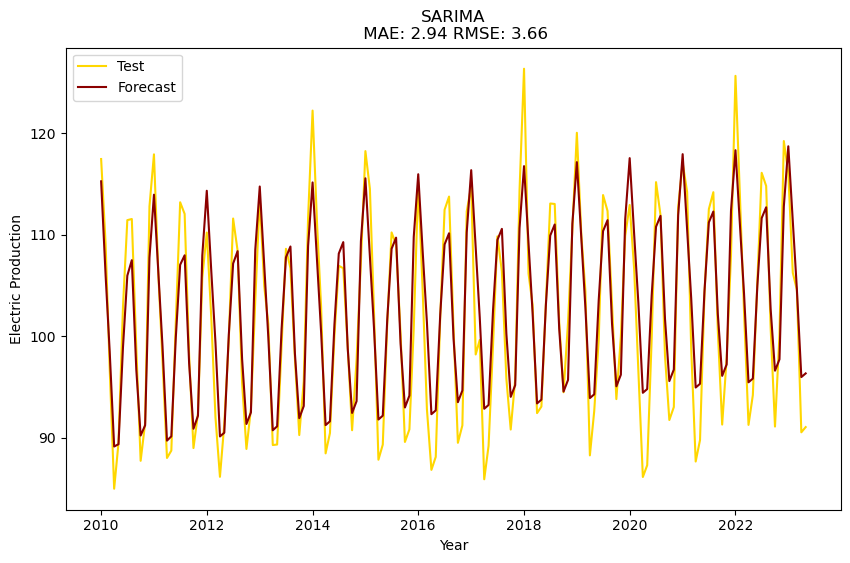

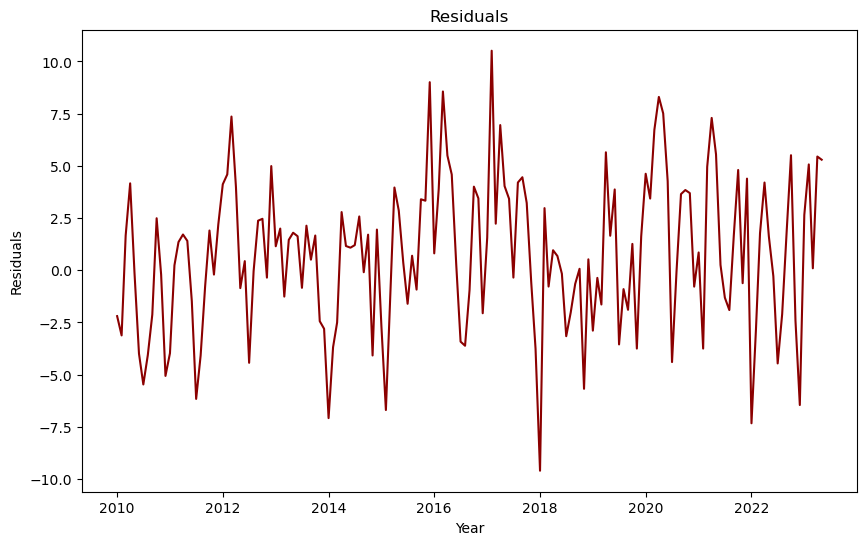

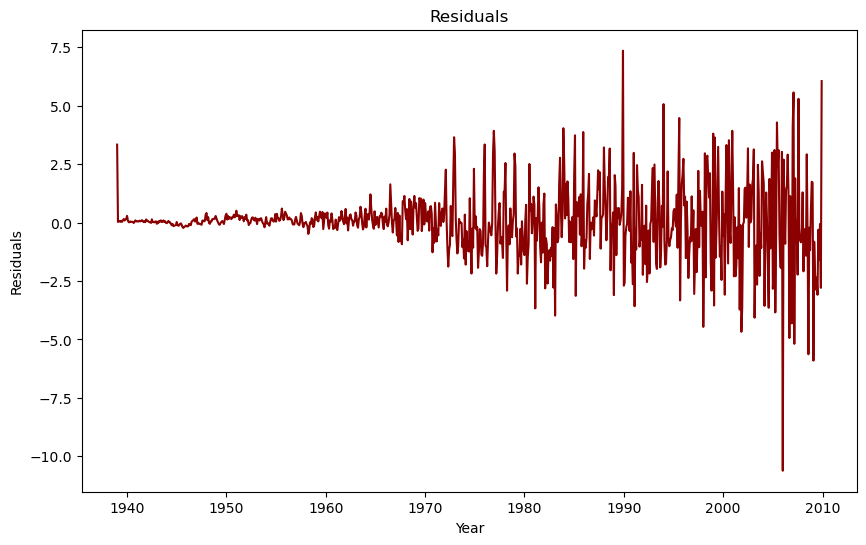

In [70]:
#plot just the predictions with the test set

plt.figure(figsize=(10, 6))
sns.lineplot(data=X_test, x=X_test.index, y=y_test, label='Test', color='gold')
sns.lineplot(data=X_test, x=X_test.index, y=forecast, label='Forecast', color='darkred')

plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('SARIMA' + '\n MAE: ' + str(round(mean_absolute_error(y_test, forecast), 2)) + ' RMSE: ' + str(round(math.sqrt(mean_squared_error(y_test, forecast)), 2)))
plt.show()

#plotting the residuals of predictions 
residuals = pd.DataFrame(forecast - y_test)
plt.figure(figsize=(10, 6))
sns.lineplot(data=residuals, x=residuals.index, y=residuals[0], color='darkred')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()



residuals = pd.DataFrame(model_fit.resid)

plt.figure(figsize=(10, 6))
sns.lineplot(data=residuals, x=residuals.index, y=residuals[0], color='darkred')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()





#### Forecasting

c:\Users\berna\anaconda3\envs\tsenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\berna\anaconda3\envs\tsenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\berna\anaconda3\envs\tsenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\berna\anaconda3\envs\tsenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


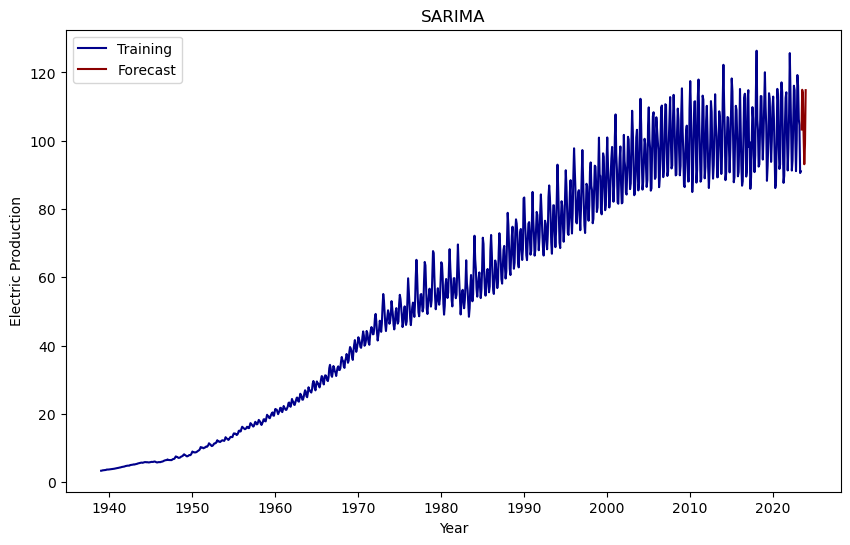

In [168]:
datacp = data.copy()
#use all the data to forecast the future
model = SARIMAX(datacp, order=(3, 1, 1), seasonal_order=(2, 0, 2, 12))

model_fit = model.fit()

forecast = model_fit.predict(start=len(datacp), end=len(datacp)+6)

plt.figure(figsize=(10, 6))
sns.lineplot(data=datacp, x=datacp.index, y=datacp['Value'], label='Training', color='darkblue')
sns.lineplot(data=forecast, x=forecast.index, y=forecast, label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('SARIMA')
plt.show()


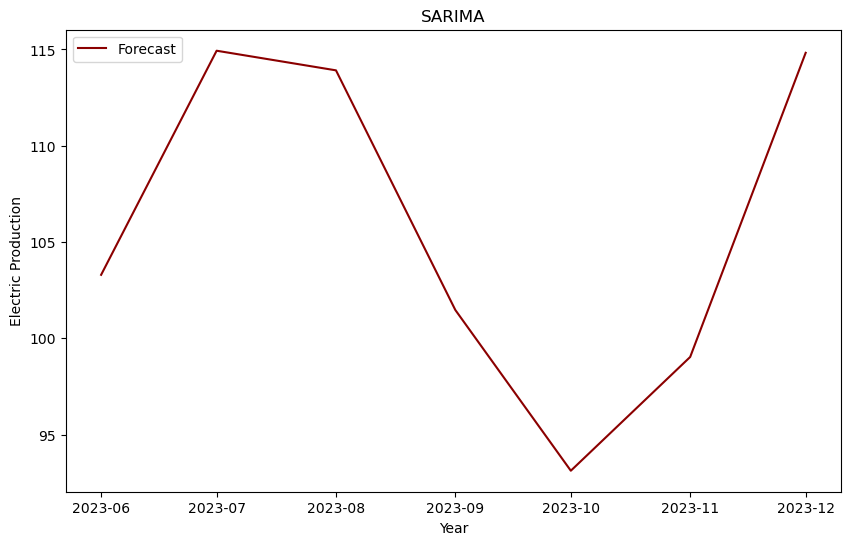

In [169]:
#plot the forecasted values
plt.figure(figsize=(10, 6))
sns.lineplot(data=forecast, x=forecast.index, y=forecast, label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('SARIMA')
plt.show()


#### Optimization: choosing best parameters

In [58]:
#use a grid search to find the best parameters
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import ParameterGrid

#ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# define the parameter values to search
p = [0, 1, 2, 3]
#d = [0, 1]
d = [0]
q = [0, 1, 2, 3]
P = [0, 1, 2]
#D = [0, 1]
D = [0]
Q = [0, 1, 2, 3]
#Q = [0, 1, 2, 3]
m = 12

# create a list with all possible combinations of parameters
param_grid = {'p': p, 'd': d, 'q': q, 'P': P, 'D': D, 'Q': Q}

# create a list to save the best models
best_models = []

# loop over all the combinations of parameters
for params in ParameterGrid(param_grid):
    try:
        # create the model with current parameters
        model = SARIMAX(y_train, order=(params['p'], params['d'], params['q']), seasonal_order=(params['P'], params['D'], params['Q'], m))  
        
        # fit the model
        model_fit = model.fit()
        
        # save the model and parameters
        best_models.append([model_fit.aic, params, model_fit])
        
        # print the parameters that yield the best AIC
        print(model_fit.aic, params)
    except:
        continue

# sort the models by the AIC values
best_models.sort()

# print the model with the best AIC
print(best_models[0])



10087.84883688849 {'D': 0, 'P': 0, 'Q': 0, 'd': 0, 'p': 0, 'q': 0}
8883.848736348351 {'D': 0, 'P': 0, 'Q': 0, 'd': 0, 'p': 0, 'q': 1}
7805.255120020758 {'D': 0, 'P': 0, 'Q': 0, 'd': 0, 'p': 0, 'q': 2}
7299.8391123736565 {'D': 0, 'P': 0, 'Q': 0, 'd': 0, 'p': 0, 'q': 3}
5514.517540080757 {'D': 0, 'P': 0, 'Q': 0, 'd': 0, 'p': 1, 'q': 0}
5209.068415959671 {'D': 0, 'P': 0, 'Q': 0, 'd': 0, 'p': 1, 'q': 1}
5046.567821430407 {'D': 0, 'P': 0, 'Q': 0, 'd': 0, 'p': 1, 'q': 2}
4857.371729819467 {'D': 0, 'P': 0, 'Q': 0, 'd': 0, 'p': 1, 'q': 3}
5371.91697667391 {'D': 0, 'P': 0, 'Q': 0, 'd': 0, 'p': 2, 'q': 0}
5208.337422334349 {'D': 0, 'P': 0, 'Q': 0, 'd': 0, 'p': 2, 'q': 1}
4954.140312036025 {'D': 0, 'P': 0, 'Q': 0, 'd': 0, 'p': 2, 'q': 2}
4851.5656518058895 {'D': 0, 'P': 0, 'Q': 0, 'd': 0, 'p': 2, 'q': 3}
4833.451157875479 {'D': 0, 'P': 0, 'Q': 0, 'd': 0, 'p': 3, 'q': 0}
4427.897524812522 {'D': 0, 'P': 0, 'Q': 0, 'd': 0, 'p': 3, 'q': 1}
4135.116008621122 {'D': 0, 'P': 0, 'Q': 0, 'd': 0, 'p': 3, 'q

In [69]:
print(best_models[1])

[14.0, {'D': 0, 'P': 2, 'Q': 0, 'd': 0, 'p': 3, 'q': 1}, <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x000001F884004FD0>]


Best model 3334.684234105589, {'D': 1, 'P': 2, 'Q': 2, 'd': 1, 'p': 3, 'q': 3}

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3525.018, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3818.742, Time=0.14 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3659.726, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3491.333, Time=0.38 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3765.501, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3491.939, Time=0.46 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3491.136, Time=0.71 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3488.056, Time=1.14 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=3458.019, Time=1.85 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=3473.850, Time=0.66 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=3503.328, Time=1.33 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=3349.064, Time=2.31 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=3363.673, Time=1.54 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=3352.274, Time=1.02 sec
 ARIMA(1,1,1)(1,1,1

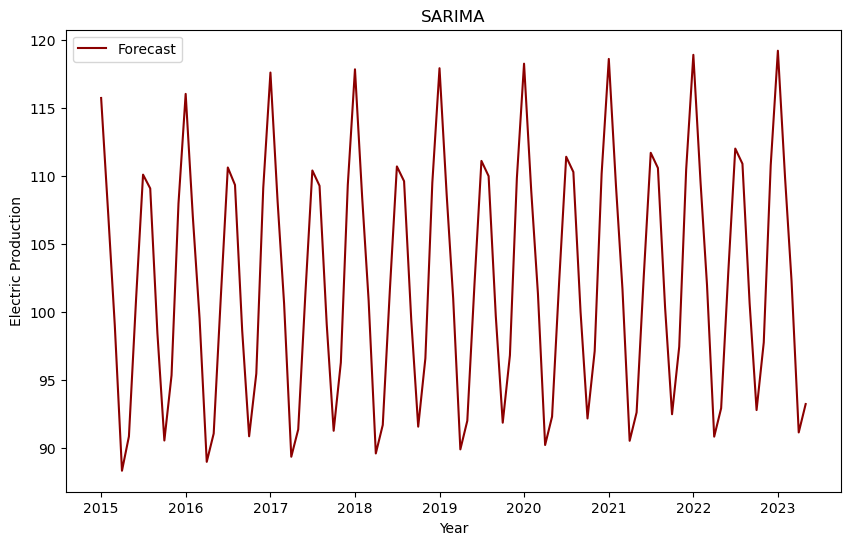

In [25]:
#optimize the choiche of the parameters using gpu acceleration and grid search with sarimax
from pmdarima import auto_arima

model = auto_arima(y_train, start_p=0, start_q=0,
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(model.summary())

#plot the forecasted values
plt.figure(figsize=(10, 6))
sns.lineplot(data=forecast, x=forecast.index, y=forecast, label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('SARIMA')
plt.show()



In [10]:
#grid search for the best parameters

# define the parameter values to search
p = [0, 1, 2, 3]
d = [0, 1]
q = [0, 1, 2, 3]
P = [0, 1, 2, 3]
D = [0, 1]
Q = [0, 1, 2, 3]
m = 12

# create a list with all possible combinations of parameters
param_grid = {'p': p, 'd': d, 'q': q, 'P': P, 'D': D, 'Q': Q}

# create a list to save the best models
best_models = []

# use grid search of scikit learn to find the best parameters

from sklearn.model_selection import GridSearchCV

# create the model
model = SARIMAX(y_train, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0))

# define the grid search parameters
#grid_search = GridSearchCV(model, param_grid, scoring='', n_jobs=-1, cv=5, verbose=3)

#define the grid search parameters with rmse
grid_search = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5, verbose=3)

# fit the grid search
grid_result = grid_search.fit(y_train)

#TypeError: Cannot clone object '' (type ): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method. so i have to define the scoring parameter in the grid search



# summarize the best parameters
#print(grid_result.best_params_)
#print(grid_result.best_score_)
#print(grid_result.best_estimator_)

# create the model with the best parameters
model = SARIMAX(y_train, order=(3, 1, 2), seasonal_order=(1, 1, 1, 12))







c:\Users\berna\anaconda3\envs\tsenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\berna\anaconda3\envs\tsenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


TypeError: Cannot clone object '<statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001F8E7761AF0>' (type <class 'statsmodels.tsa.statespace.sarimax.SARIMAX'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [128]:
#use a neural network to forecast the future
datacpy = data.copy()
#split the data into train and test train from 1939 to 2010
train = datacpy.iloc[:852]
test = datacpy.iloc[852:]

#scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

#use a generator to feed the data to the neural network
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
n_input = 24
n_features = 1  
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

#build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

#fit the model
model.fit_generator(generator, epochs=50)

#plot the loss
losses = pd.DataFrame(model.history.history)
losses.plot()

#use the model to predict the test data
first_eval_batch = scaled_train[-n_input:]
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)

#forecast the test data


Epoch 1/50


C:\Users\berna\AppData\Local\Temp\ipykernel_6880\94939545.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=50)


820/828 [============================>.] - ETA: 0s - loss: 0.0079

KeyboardInterrupt: 

In [125]:
#use a S-RNN (seasonal recurrent neural network)
#use a generator to feed the data to the neural network
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

#build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
model = Sequential()  
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features), return_sequences=True))  
model.compile(optimizer='adam', loss='mse')


#fit the model
model.fit_generator(generator, epochs=50)

#plot the loss
losses = pd.DataFrame(model.history.history)
losses.plot()

#use the model to predict the test data
first_eval_batch = scaled_train[-n_input:]
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)



Epoch 1/50


C:\Users\berna\AppData\Local\Temp\ipykernel_6880\4101148992.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=50)


426/828 [==============>...............] - ETA: 5s - loss: 0.2004

KeyboardInterrupt: 

In [126]:
#plot the predictions against the test data
test_predictions = []
first_eval_batch = scaled_train[-n_input:]

current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(12, 8))



1/1 [==============================] - 0s 172ms/step


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

In [83]:
train

Value
DATE                
1939-01-01    3.3336
1939-02-01    3.3591
1939-03-01    3.4354
1939-04-01    3.4609
1939-05-01    3.4609
...              ...
2009-08-01  104.4211
2009-09-01   93.6745
2009-10-01   88.0479
2009-11-01   88.1245
2009-12-01  109.2273

[852 rows x 1 columns]

KeyError: 'Predictions'

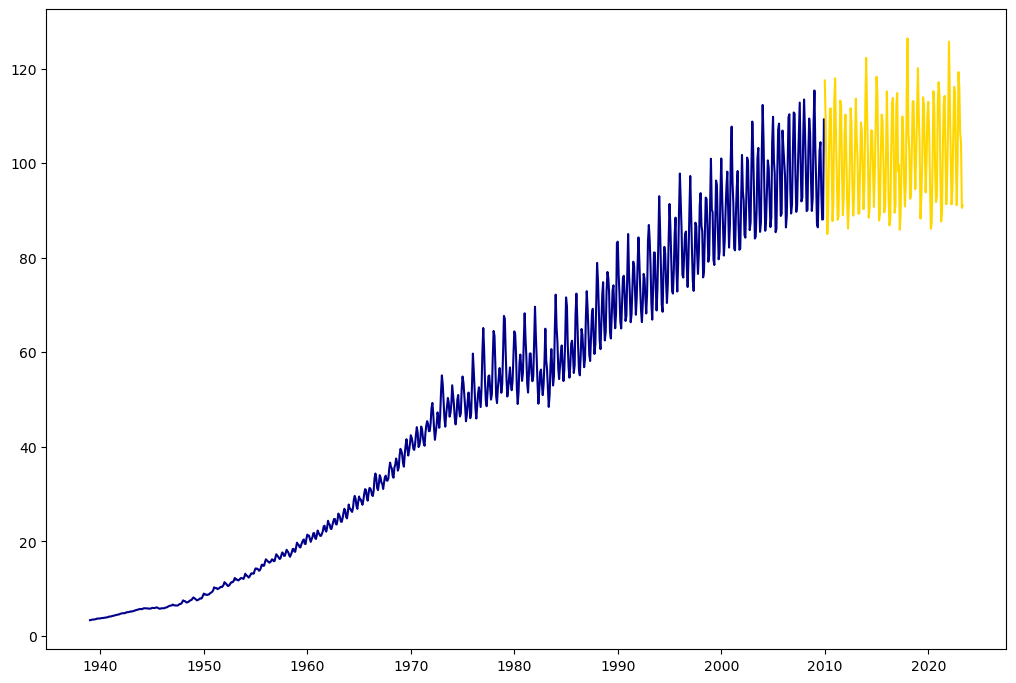

In [127]:
#plot the predictions against the test data attached to the train data
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(train.index, train['Value'], label='Train', color='darkblue')   
ax.plot(test.index, test['Value'], label='Test', color='gold')
ax.plot(test.index, test['Predictions'], label='Predictions', color='darkred')
ax.legend(loc=0)
ax.set_xlabel('Year')
ax.set_ylabel('Electric Production')
ax.set_title('Neural Network')
plt.show()








In [87]:
#evaluate the model with rmse and mae
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(sqrt(mean_squared_error(test['Value'], test['Predictions'])))
print(mean_absolute_error(test['Value'], test['Predictions']))



7.070293721916155
5.6365453879527845


In [121]:
#plot using the whole dataset to plot with sns the predictions till 2030 and compare them with the real data
test_predictions = []
first_eval_batch = scaled_train[-n_input:]

current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(120):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

true_predictions = scaler.inverse_transform(test_predictions)

#plot the predictions
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=true_predictions, x=data.index[-120:], y=true_predictions.reshape(-1), label='Forecast', color='darkred')
# plt.xlabel('Year')
# plt.ylabel('Electric Production')
# plt.title('Neural Network')
# plt.show()


1/1 [==============================] - 0s 30ms/step


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

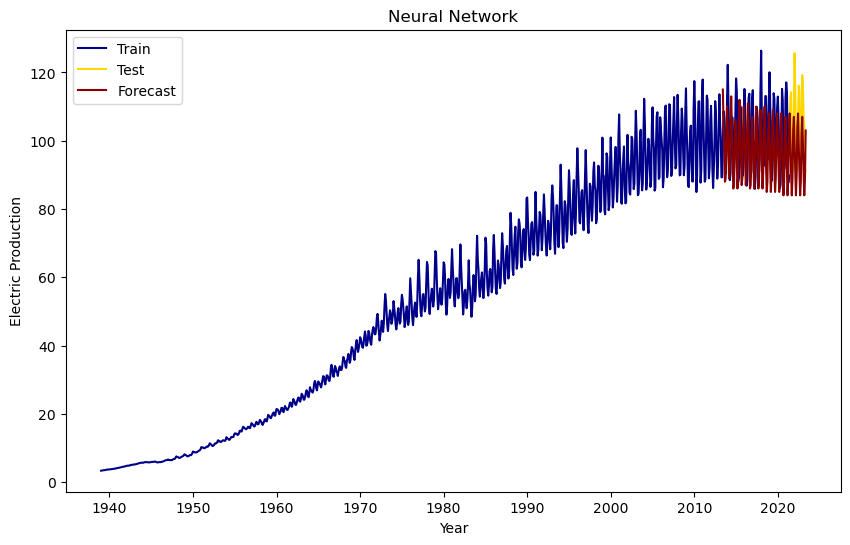

In [75]:
#convert true_predictions in an integer array
#plot the predictions with plot over the real data and at the end of the training set plot the predictions using plt.plot and not sns.lineplot
true_predictions = true_predictions.astype(int)
plt.figure(figsize=(10, 6))
#plot train data
plt.plot(data.index[:-24], data['Value'][:-24], label='Train', color='darkblue')
#plot test data
plt.plot(data.index[-24:], data['Value'][-24:], label='Test', color='gold')
plt.plot(data.index[-120:], true_predictions.reshape(-1), label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.legend()
plt.title('Neural Network')
plt.show()







In [107]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=true_predictions, x=data.index[-120:], y=true_predictions.reshape(-1), label='Forecast', color='darkred')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Neural Network')
plt.show()


IndexError: arrays used as indices must be of integer (or boolean) type

<Figure size 1000x600 with 0 Axes>

In [97]:
# evaluate the model
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test['Value'], test['Predictions'])) 
print(rmse)



4.9093585738351395


## CrossValidation approach

### Splitting

In [108]:
y_valid

DATE
2015-10-01     89.5855
2015-11-01     90.8250
2015-12-01    100.7938
2016-01-01    115.1674
2016-02-01    104.3863
                ...   
2023-01-01    116.0803
2023-02-01    106.2589
2023-03-01    104.5990
2023-04-01     90.5375
2023-05-01     91.0514
Name: Value, Length: 92, dtype: float64

In [112]:
folds

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)

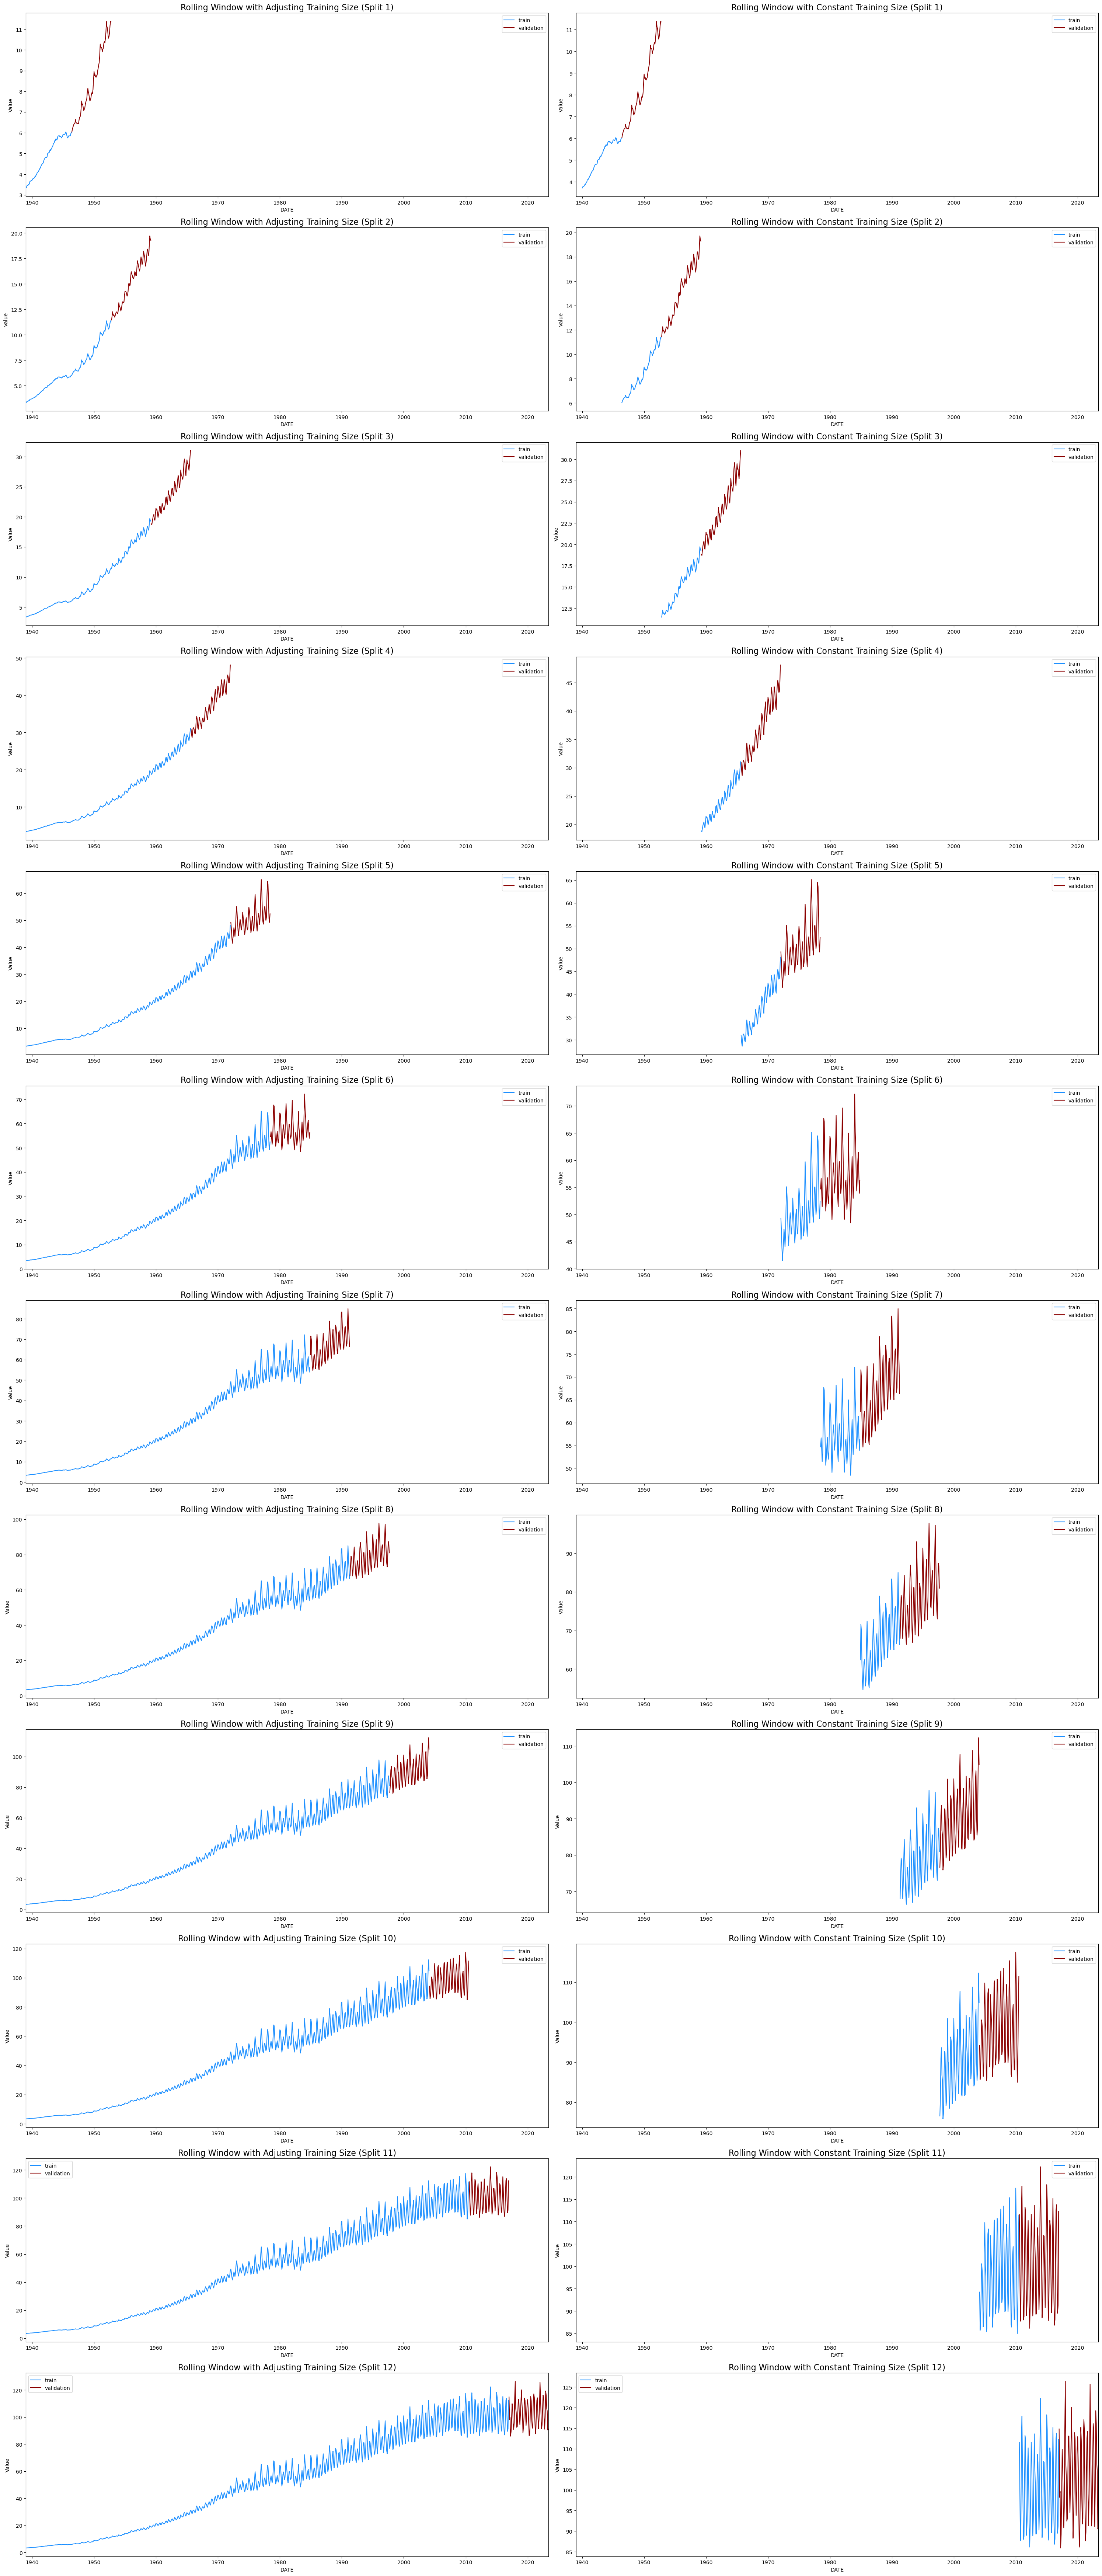

In [159]:
from datetime import date
from sklearn.model_selection import TimeSeriesSplit

#print all the date of data
X = data.index
y = data['Value']

N_SPLITS = 12

folds = TimeSeriesSplit(n_splits=N_SPLITS)

f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(30, 70))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(x= X_train, y= y_train, ax=ax[i,0], color='dodgerblue', label='train')
    sns.lineplot(x= X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
                 y= y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
                 ax=ax[i,1], color='dodgerblue', label='train')

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkred', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(1939, 1, 1), date(2023, 5, 1)])
    ax[i, 1].set_xlim([date(1939, 1, 1), date(2023, 5, 1)])
plt.tight_layout()
plt.show()

In [39]:
folds.split(5)

<generator object TimeSeriesSplit.split at 0x000001B103375C80>

### Moving average CV

c:\Users\berna\anaconda3\envs\tsenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\berna\anaconda3\envs\tsenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\berna\anaconda3\envs\tsenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\berna\anaconda3\envs\tsenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
No artists with labels found to put in legend.  Note that artists whose label 

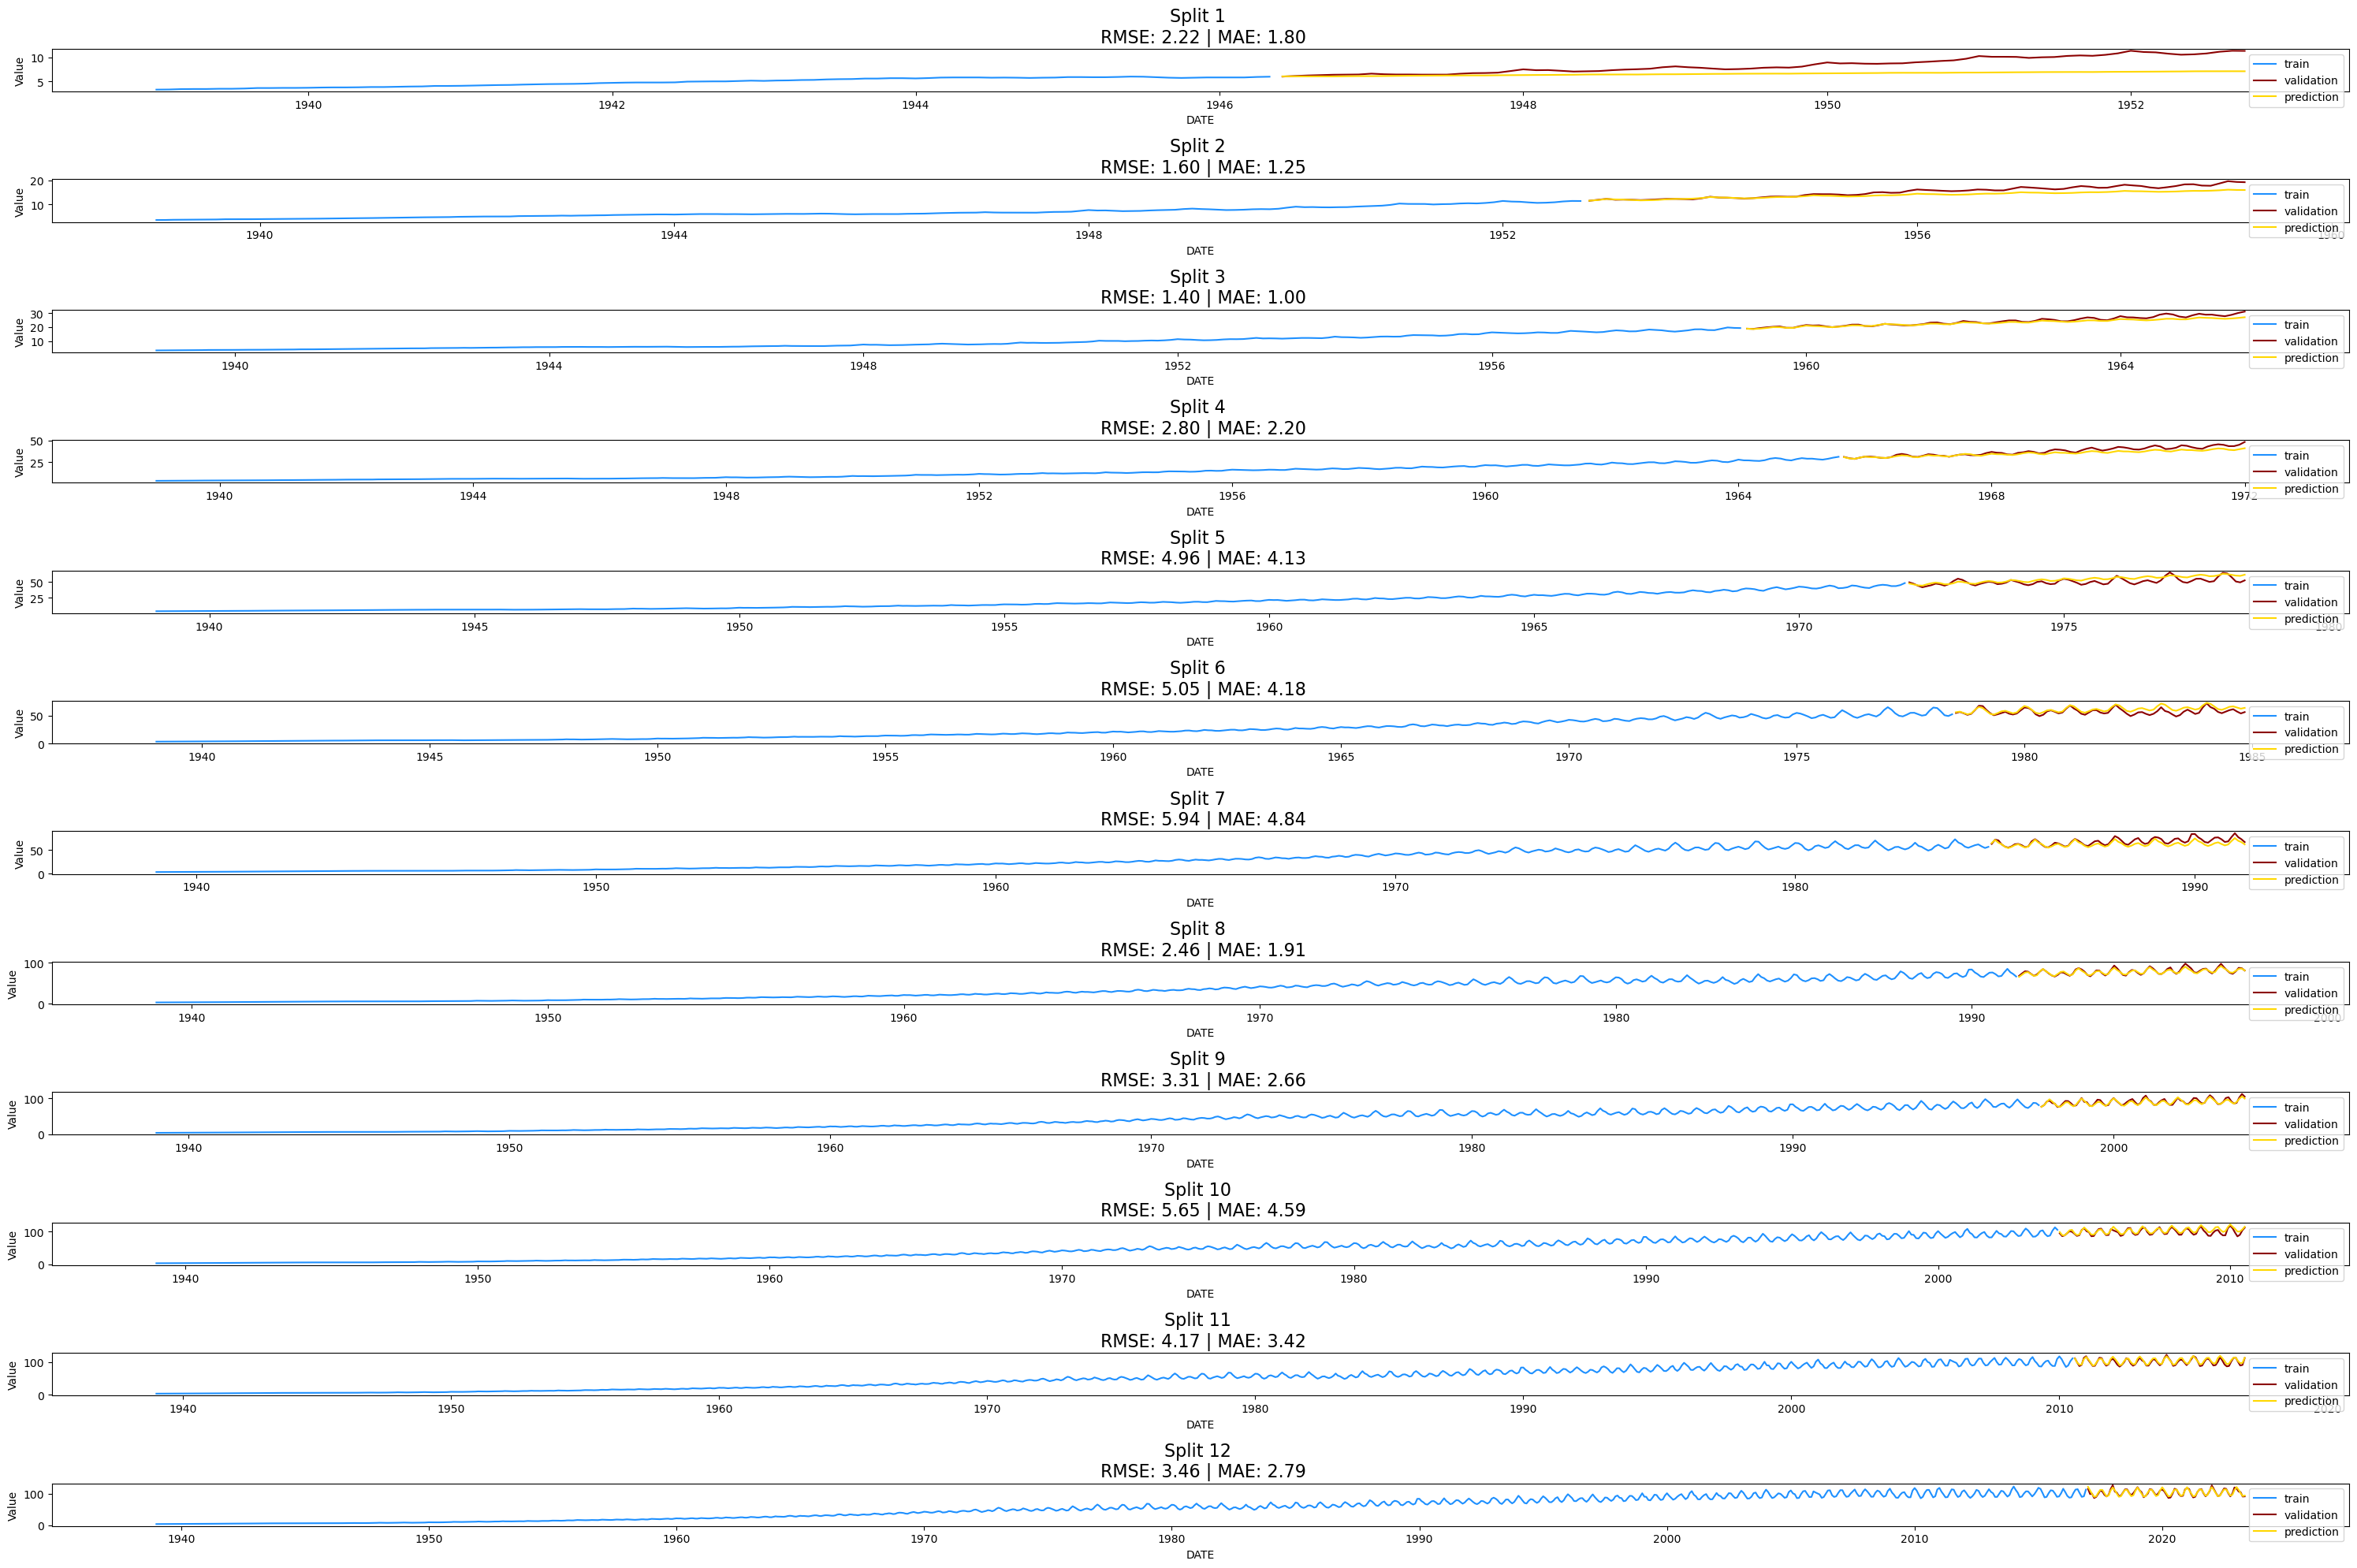

3.5876559782179327
2.8981223999864008


In [170]:
#moving average cross validation 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt
#exponential smoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

X = data.index
y = data['Value']

N_SPLITS = 12

folds = TimeSeriesSplit(n_splits=N_SPLITS)

# create a for loop that iterates through each fold in the TimeSeriesSplit object
# note: this is not the same as train_test_split or KFold
rmse_scores = [] # this will be used to collect the RMSE for each train/validation fold
mae_scores = []
index = 0

#plot prediction in one graph
f,ax = plt.subplots(figsize=(30, 20), nrows=N_SPLITS, ncols=1)


for train_index, val_index in folds.split(X):
    index += 1
    # split train-test
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # instantiate moving average model naive approach just moving average so the parameters are 0,0,0 
    #model = ARIMA(endog=y_train, order=(0, 0, 2))
    #model = ARIMA(endog=y_train, order=(0, 0, 1))
    #model = ARIMA(endog=y_train, order=(1, 1, 0))
    #moving average naive approach
    #exponential smoothing
    #model = SimpleExpSmoothing(endog=y_train)
    #double exponential smoothing
    #model = Holt(endog=y_train)
    #triple exponential smoothing
    #model = ExponentialSmoothing(endog=y_train, trend='add', seasonal='add', seasonal_periods=12)
    #sarima
    #model = SARIMAX(endog=y_train, order=(3,1,1), seasonal_order=(2,0,2, 12))
    #model = SARIMAX(endog=y_train, order=(1, 1, 2), seasonal_order=(1, 0, 1, 12))
    # fit model
    model_fit = model.fit()

    # generate predictions
    predictions = model_fit.predict(start=X_val[0], end=X_val[-1])

    # calculate metrics
    rmse = sqrt(mean_squared_error(y_val, predictions))
    mae = mean_absolute_error(y_val, predictions)
    
    # append to appropriate list
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    # plot data
    sns.lineplot(x=X_train, y=y_train, color='dodgerblue', label='train', ax=ax[index-1])
    sns.lineplot(x=X_val, y=y_val, color='darkred', label='validation', ax=ax[index-1])
    sns.lineplot(x=X_val, y=predictions, color='gold', label='prediction', ax=ax[index-1])
    #plt.title(f"Split {index} \n Train RMSE: {rmse:.2f} | Train MAE: {mae:.2f}")
    ax[index-1].set_title(f"Split {index} \n RMSE: {rmse:.2f} | MAE: {mae:.2f}", fontsize=16)
    plt.legend(loc='best')
    


plt.tight_layout()
plt.show()
# print mean metrics
print(np.mean(rmse_scores))
print(np.mean(mae_scores))





Text(0.5, 1.0, 'Split 12 \n Train RMSE: 3.46 | Train MAE: 2.79')

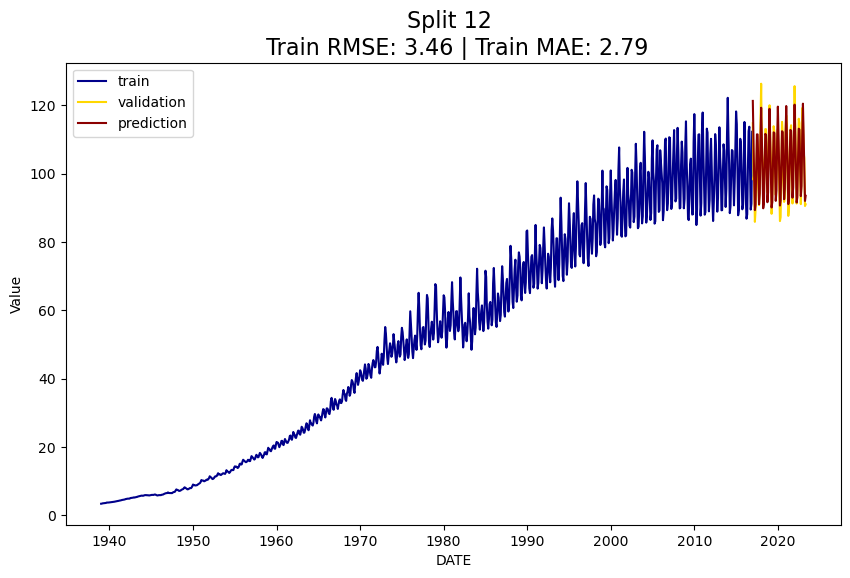

In [158]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=X_train, y=y_train, color='darkblue', label='train')
sns.lineplot(x=X_val, y=y_val, color='gold', label='validation')
sns.lineplot(x=X_val, y=predictions, color='darkred', label='prediction')
plt.title(f"Split {index} \n Train RMSE: {rmse:.2f} | Train MAE: {mae:.2f}", fontsize=16)

In [22]:
# arima with cross validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

#remove warnings
import warnings
warnings.filterwarnings("ignore")

X = data.index
y = data['Value']

N_SPLITS = 10

folds = TimeSeriesSplit(n_splits=N_SPLITS)

RMSE = []
MAE = []

for train_index, test_index in folds.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = ARIMA(y_train, order=(3, 1, 2))
    model_fit = model.fit()
    y_pred = model_fit.predict(len(y_train), len(y_train) + len(y_test) - 1, typ='levels')

    RMSE.append(sqrt(mean_squared_error(y_test, y_pred)))
    MAE.append(mean_absolute_error(y_test, y_pred))

    
print(np.mean(RMSE))
print(np.mean(MAE))




6.590954235883754
5.562183300751369


In [13]:
y_pred

2015-10-01     90.842909
2015-11-01     93.810563
2015-12-01    105.995031
2016-01-01    115.221755
2016-02-01    112.273672
                 ...    
2023-01-01    114.784932
2023-02-01    112.218535
2023-03-01    100.486088
2023-04-01     91.316319
2023-05-01     93.869416
Freq: MS, Name: predicted_mean, Length: 92, dtype: float64

In [149]:
#plot the predictions with plot over the real data and at the end of the training set plot the predictions using sns.lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=y_test, x=X_test, y=y_test, label='Test', color='gold')
sns.lineplot(data=y_pred, x=X_test, y=y_pred, label='Forecast', color='darkred')
sns.lineplot(data=y_train, x=X_train, y=y_train, label='Train', color='darkblue')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Crossa Validated ARIMA \n RMSE: ' + str(round(np.mean(RMSE), 2)) + ' MAE: ' + str(round(np.mean(MAE), 2)))
plt.show()


ValueError: Data must be 1-dimensional

<Figure size 1000x600 with 0 Axes>

In [174]:
#SARIMA with cross validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt

#remove warnings
import warnings
warnings.filterwarnings("ignore")

X = data.index
y = data['Value']

N_SPLITS = 12

folds = TimeSeriesSplit(n_splits=N_SPLITS)

#TO DO TO DO TO DO TO DO TO DO TO DO TO DO TO DO TO DO TO DO separate test set and validation set

RMSE = []
MAE = []

for train_index, test_index in folds.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = SARIMAX(y_train, order=(3, 1, 1), seasonal_order=(2, 0, 2, 12))
    model_fit = model.fit()
    y_pred = model_fit.predict(len(y_train), len(y_train) + len(y_test) - 1, typ='levels')

    RMSE.append(sqrt(mean_squared_error(y_test, y_pred)))
    MAE.append(mean_absolute_error(y_test, y_pred))


print(np.mean(RMSE))
print(np.mean(MAE))
    

3.5876559782179327
2.8981223999864008


In [38]:
MAE
RMSE

[0.23626854048237503,
 0.3750734459924632,
 0.5957326321551746,
 0.7403936412680342,
 0.22124723091389778,
 0.24861018884133823,
 0.45595114009430016,
 0.28111411252194046,
 0.2752244328726335,
 0.4282454480924502,
 0.7773291965458919,
 0.7231291164097244,
 1.447397192373635,
 1.0628575646244889,
 2.6148591675878663,
 2.9386963207187886,
 2.4352351750628394,
 1.728831039602242,
 3.163290280612953,
 3.6120818810001536,
 6.636765872985726,
 1.3628617356643806,
 3.237214568433906,
 2.303628230231408,
 2.280973549444883,
 1.7396173641876047,
 2.3106254468291745,
 2.7502328038014596,
 2.565675469919068,
 3.044696149285766,
 2.083938706216679,
 3.6102134771511665,
 2.973789973971585,
 3.1872760175614125,
 3.3011212714766995,
 3.6455354890326968,
 4.379649150064174,
 4.106134379582759,
 3.849327567658233,
 3.0050285821108687]

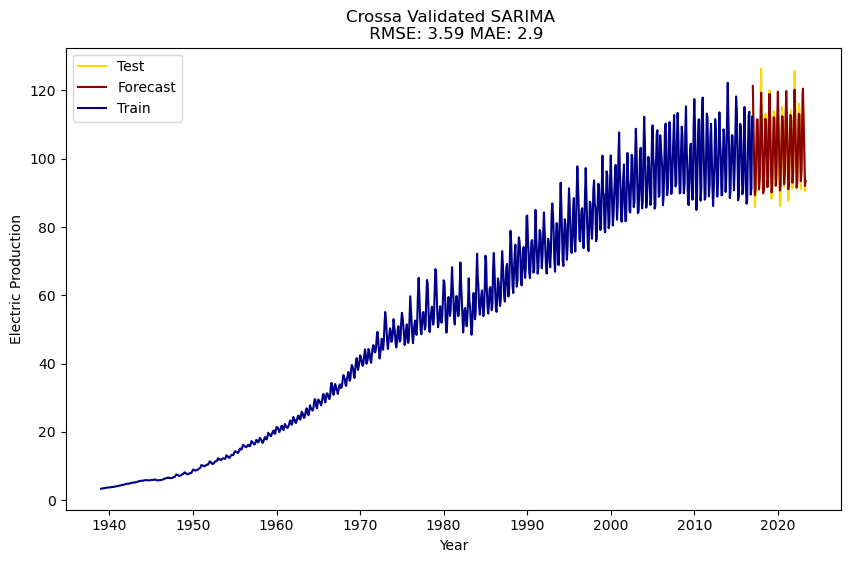

In [175]:
#plot the predictions with plot over the real data and at the end of the training set plot the predictions using sns.lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=y_test, x=X_test, y=y_test, label='Test', color='gold')
sns.lineplot(data=y_pred, x=X_test, y=y_pred, label='Forecast', color='darkred')
sns.lineplot(data=y_train, x=X_train, y=y_train, label='Train', color='darkblue')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Crossa Validated SARIMA \n RMSE: ' + str(round(np.mean(RMSE), 2)) + ' MAE: ' + str(round(np.mean(MAE), 2)))
plt.show()

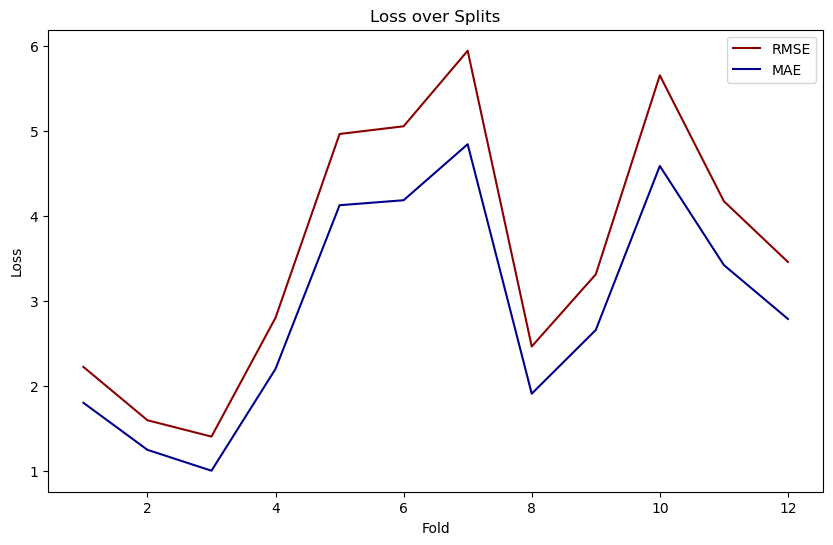

In [176]:
#plot loss 
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, N_SPLITS + 1), y=RMSE, label='RMSE', color='darkred')
sns.lineplot(x=range(1, N_SPLITS + 1), y=MAE, label='MAE', color='darkblue')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('Loss over Splits')
plt.show()
